# DATA 620 - Project 2 (Week 7)

## Introduction
In this project, we explore so-called cross-sectional price momentum in the current single stock constituents of the S&P500 equity index using a bipartite graph representing the relationships between single stocks and indicators of the type of relative momentum that can be exploited by a simple systematic trading approach. We use sector and sub-industry categorical data for each of the stocks comprising the current S&P500 to help interpret groups of stocks identified using a number of community detection methods.

In the first section, data required to perform our research is acquired through a combination of web-scraping and the use of an API.

In the second section, we build and explore a bipartite graph representing the relationships between single stocks in the S&P500 instrument universe and the conditions associated the trading signals of a simple equity momemtum trading system.

In the third section, we employ a number of community detection approaches to identify groups of stocks with common characteristics.

In the last section, we present conclusions.

## Data Acquisition & Cleaning
To perform the analysis briefly outlined above, we require a list of the current constituents of the S&P500 index, along with corresponding sector, sub-industry, and price data.
We start by acquiring the required data. The first part of the data set - the instrument master for our universe under study - is scraped from Wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). The second part of our data set - corresponding prices for each instrument - are collected from Yahoo finance using the 'pandas_datareader' package.

We start by loading all of the packages used in the project.

In [532]:
import pandas_datareader
import pandas
import math
import numpy
from scipy import stats
import datetime
import time

import urllib2
from bs4 import BeautifulSoup
from timeit import default_timer as timer
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn

import networkx
import networkx.algorithms.bipartite as bipartite
import community

# inline matplotlib
%matplotlib inline

We define the functions required to fetch the instrument master and price data for the universe of single stock constituents of the S&P500 and compute the indicators used in generating signals associated with a simple equity momentum trading system  as follows:

In [534]:
def ensure_directory(f):
    d = os.path.dirname(f)
    if not os.path.exists(d):
        os.makedirs(d)

def fetchSP500_components_wiki(outputDirectory,endDate):

    outputFileName="sp-500_constituents_"+endDate.strftime('%Y%m%d_%H%M%S')
    #
    outputFileHandle = open( outputDirectory + outputFileName,'w')

    url="http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    # fetch the url
    req = urllib2.Request(url, headers={'User-Agent' : "Magic Browser"}) 
    response = urllib2.urlopen( req ) 
    s = response.read()
    response.close()
    # 
    soup = BeautifulSoup(s, "lxml")
        
    # fetch the table
    table = soup.find("table", attrs={"class":"wikitable sortable"})    
    # fetch the returns
    records = table.find_all(["tr"])

    
    # iterate over the table line for each component
    for record in records:
        # parse the line    
        line=record.text.split('\n')
        instrumentTicker=str(line[1])
        instrumentName=str(line[2])
        sector=str(line[4])
        subIndustry=str(line[5])
        CIK=str(line[8])

        lineArray=list()
        lineArray.append(instrumentTicker)
        lineArray.append(instrumentName)
        lineArray.append(sector)
        lineArray.append(subIndustry)
        lineArray.append(CIK)

        # write line to the output file
        try:
            lineString='|'.join(lineArray)
            print(lineString)
            outputFileHandle.write(lineString+"\n")
        except:
            print('cannot write')

    # close the output file
    outputFileHandle.close()

    return outputFileName

def price2momentum(y):
    x=numpy.arange(0,len(y))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,
        numpy.log(y))
    # adjust the momentum for smoothness and annualize
    momentum=(((1+slope)**252)-1)*(r_value**2)
    return momentum

def priceGapFilter(y):
    # set gap filter
    threshold=0.15
    # find gap flag
    gapFlag=numpy.max(numpy.abs(numpy.diff(numpy.log(y))))>=threshold

    return gapFlag

# fetch yahoo data for ticker between start and end dates
def fetchYahooData(yahooTicker,instrumentName,gicsSectorName,gicsSubIndustryName,
    cik,startDate,endDate,momentumLookback=80,momentumLookback0=90,
    momentumLookback1=100,momentumLookback2=110,momentumLookback3=120,
    gapLookback=80,gapLookback0=90,gapLookback1=100,gapLookback2=110,
    gapLookback3=120,emaLookback=90,emaLookback0=100,emaLookback1=120,
    emaLookback2=150,emaLookback3=200):

    # fetch historical data
    df = pandas_datareader.data.DataReader(yahooTicker, 'yahoo', startDate, 
        endDate)

    # iterate backwards over the prices and compute the adj factor
    df1=df.copy(deep=True)

    #dateTime=df1.index
    openPrice=numpy.array(df1['Open'].values, dtype='d')
    highPrice=numpy.array(df1['High'].values, dtype='d')
    lowPrice=numpy.array(df1['Low'].values, dtype='d')
    closePrice=numpy.array(df1['Close'].values, dtype='d')
    adjustedClosePrice=numpy.array(df1['Adj Close'].values, dtype='d')
        
    T=len(df)
    adjustCount=0
    for t in xrange(T-1,-1,-1):
       
        if closePrice[t] != adjustedClosePrice[t]:
            factor = adjustedClosePrice[t]/closePrice[t]
            adjustCount=adjustCount+1
            
            for tt in xrange(t,-1,-1):
                openPrice[tt]=openPrice[tt]*factor
                highPrice[tt]=highPrice[tt]*factor
                lowPrice[tt]=lowPrice[tt]*factor
                closePrice[tt]=closePrice[tt]*factor                

    df['adjOpen']=numpy.array(openPrice, dtype='d')
    df['adjHigh']=numpy.array(highPrice, dtype='d')
    df['adjLow']=numpy.array(lowPrice, dtype='d')
    df['adjClose']=numpy.array(closePrice, dtype='d')
                            
    # add true range and 20d ATR
    previousClosePrice=df['adjClose'].shift(1)
    a=df['adjHigh']-df['adjLow']
    b=abs(df['adjHigh']-previousClosePrice)
    c=abs(previousClosePrice-df['adjLow'])
    test=pandas.concat([a,b,c],axis=1)
    # compute true range
    trueRange=test.max(axis=1,skipna=False)
    trueRange.reindex(df.index,method='ffill')
    df['trueRange']=trueRange
    # compute the 20d atr
    atrLookback=20
    
    atr=trueRange.ewm(span=atrLookback,min_periods=atrLookback,adjust=True,
        ignore_na=True).mean()
    
    df['atr_20d']=numpy.array(numpy.around(atr, decimals=2, out=None), 
      dtype='d')

    # add momentum
    df['momentum_'+str(momentumLookback)+'d']=df['adjClose'].rolling(center=False,
       window=momentumLookback).apply(func=price2momentum)
    # add momentum
    df['momentum_'+str(momentumLookback0)+'d']=df['adjClose'].rolling(center=False,
       window=momentumLookback0).apply(func=price2momentum)    
    # add momentum
    df['momentum_'+str(momentumLookback1)+'d']=df['adjClose'].rolling(center=False,
       window=momentumLookback1).apply(func=price2momentum)
    # add momentum
    df['momentum_'+str(momentumLookback2)+'d']=df['adjClose'].rolling(center=False,
       window=momentumLookback2).apply(func=price2momentum)
    # add momentum
    df['momentum_'+str(momentumLookback3)+'d']=df['adjClose'].rolling(center=False,
       window=momentumLookback3).apply(func=price2momentum)    
        
    # add gap flag
    df['gapFlag_'+str(gapLookback)+'d']=df['adjClose'].rolling(center=False,
       window=gapLookback).apply(func=priceGapFilter)    
    # add gap flag
    df['gapFlag_'+str(gapLookback0)+'d']=df['adjClose'].rolling(center=False,
       window=gapLookback0).apply(func=priceGapFilter)
    # add gap flag
    df['gapFlag_'+str(gapLookback1)+'d']=df['adjClose'].rolling(center=False,
       window=gapLookback1).apply(func=priceGapFilter)    
    # add gap flag
    df['gapFlag_'+str(gapLookback2)+'d']=df['adjClose'].rolling(center=False,
       window=gapLookback2).apply(func=priceGapFilter)    
    # add gap flag
    df['gapFlag_'+str(gapLookback3)+'d']=df['adjClose'].rolling(center=False,
       window=gapLookback3).apply(func=priceGapFilter)

    # compute EMA price
    df['emaPrice_'+str(emaLookback)+'d']=df['adjClose'].ewm(span=emaLookback,
       min_periods=0,ignore_na=True).mean()
    # compute EMA price
    df['emaPrice_'+str(emaLookback0)+'d']=df['adjClose'].ewm(span=emaLookback0,
       min_periods=0,ignore_na=True).mean()
    # compute EMA price
    df['emaPrice_'+str(emaLookback1)+'d']=df['adjClose'].ewm(span=emaLookback1,
       min_periods=0,ignore_na=True).mean()
    # compute EMA price
    df['emaPrice_'+str(emaLookback2)+'d']=df['adjClose'].ewm(span=emaLookback2,
       min_periods=0,ignore_na=True).mean()
    # compute EMA price
    df['emaPrice_'+str(emaLookback3)+'d']=df['adjClose'].ewm(span=emaLookback3,
       min_periods=0,ignore_na=True).mean()

    # add trend flag
    columnLabelA='trendFlag_'+str(emaLookback)+'d'
    columnLabelB='emaPrice_'+str(emaLookback)+'d'
    df[columnLabelA]=df['adjClose']>df[columnLabelB].shift(periods=-1,axis=0)
    # add trend flag
    columnLabelA='trendFlag_'+str(emaLookback0)+'d'
    columnLabelB='emaPrice_'+str(emaLookback0)+'d'
    df[columnLabelA]=df['adjClose']>df[columnLabelB].shift(periods=-1,axis=0)
    # add trend flag
    columnLabelA='trendFlag_'+str(emaLookback1)+'d'
    columnLabelB='emaPrice_'+str(emaLookback1)+'d'
    df[columnLabelA]=df['adjClose']>df[columnLabelB].shift(periods=-1,axis=0)
    # add trend flag
    columnLabelA='trendFlag_'+str(emaLookback2)+'d'
    columnLabelB='emaPrice_'+str(emaLookback2)+'d'
    df[columnLabelA]=df['adjClose']>df[columnLabelB].shift(periods=-1,axis=0)
    # add trend flag
    columnLabelA='trendFlag_'+str(emaLookback3)+'d'
    columnLabelB='emaPrice_'+str(emaLookback3)+'d'
    df[columnLabelA]=df['adjClose']>df[columnLabelB].shift(periods=-1,axis=0)
        
    # add NA for last point to ensure causal
    df['trendFlag_'+str(emaLookback)+'d'].iloc[T-1]=numpy.nan
    # add NA for last point to ensure causal
    df['trendFlag_'+str(emaLookback0)+'d'].iloc[T-1]=numpy.nan
    # add NA for last point to ensure causal
    df['trendFlag_'+str(emaLookback1)+'d'].iloc[T-1]=numpy.nan
    # add NA for last point to ensure causal
    df['trendFlag_'+str(emaLookback2)+'d'].iloc[T-1]=numpy.nan
    # add NA for last point to ensure causal
    df['trendFlag_'+str(emaLookback3)+'d'].iloc[T-1]=numpy.nan    
    
    # add instrument info
    df['yahooTicker']=str(yahooTicker)
    df['instrumentName']=str(instrumentName)
    df['gicsSectorName']=str(gicsSectorName)
    df['gicsSubIndustryName']=str(gicsSubIndustryName)
    df['cik']=str(cik)
    
    return df

def buildMomentumData(priceDirectory,instrumentMaster,startDate,endDate):

    # create data dictionary
    dataDictionary=dict()
    # create error dictionary
    error=dict()
    
    # iterate over each instrument
    for instrument_index, instrument in instrumentMaster.iterrows():
        # extract instrument details
        instrumentTicker=instrument[0]
        instrumentName=instrument[1]
        gicsSectorName=instrument[2]
        gicsSubIndustryName=instrument[3]
        cik=instrument[4]
    
        rowList=list()

        try:

            # create output file name
            priceFileName=instrumentTicker+'_'+endDate.strftime('%Y%m%d_%H%M%S')
            # fetch price from yahoo
            price=fetchYahooData(instrumentTicker,instrumentName,gicsSectorName,
                gicsSubIndustryName,cik,startDate,endDate)
            # write price
            price.to_csv(priceDirectory+priceFileName,sep='|',index=True,
                index_label='asOfDate',float_format='%g',na_rep='\N')

            # store fields in array
            rowList.append("COMPLETE")
            rowList.append(instrumentTicker)
            rowList.append(instrumentName)
            rowList.append(gicsSectorName)
            rowList.append(gicsSubIndustryName)
            rowList.append(endDate.strftime('%Y-%m-%d %H:%M:%S'))
            # create row string
            rowString='|'.join(rowList)

            # log complete
            print(rowString)
            errorHandle.write(rowString+"\n")
            # sleep for 10 seconds
            time.sleep(10)
            # add price dataframe to data dictionary 
            dataDictionary[instrumentTicker]=price

        except:  
            # store in array
            rowList.append("ERROR")
            rowList.append(instrumentTicker)
            rowList.append(instrumentName)
            rowList.append(gicsSectorName)
            rowList.append(gicsSubIndustryName)
            rowList.append(endDate.strftime('%Y-%m-%d %H:%M:%S'))        
            # create row string
            rowString='|'.join(rowList)
        
            # log error
            print(rowString)
            errorHandle.write(rowString+"\n")
            # add instrument name to error dictionary
            error[instrumentTicker]=instrumentName
        
    # close error log
    errorHandle.close()  
        
    # convert the error dictionary to a dataframe
    errorData=pandas.DataFrame.from_dict(error,orient='index')            
   
    # create the data panel
    groupData=pandas.Panel.from_dict(dataDictionary,orient='minor')    
    
    return groupData,errorData

def writeMomentumData2h5(baseDirectory,groupData):
    # extract the prices
    prices=groupData['adjClose']
    # extract the true ranges
    trueRanges=groupData['trueRange']

    # momentumLookback=80
    # extract the 80-day momentum
    momentum_80d=groupData['momentum_80d']
    # momentumLookback0=90
    # extract the 90-day momentum
    momentum_90d=groupData['momentum_90d']
    # momentumLookback1=100
    # extract the 100-day momentum
    momentum_100d=groupData['momentum_100d']
    # momentumLookback2=110
    # extract the 110-day momentum
    momentum_110d=groupData['momentum_110d']
    # momentumLookback3=120
    # extract the 120-day momentum
    momentum_120d=groupData['momentum_120d']
    
    # gapLookback=80
    # extract the 80-day gap flag
    gapFlag_80d=groupData['gapFlag_80d']
    # gapLookback0=90
    # extract the 90-day gap flag
    gapFlag_90d=groupData['gapFlag_90d']
    # gapLookback1=100
    # extract the 100-day gap flag
    gapFlag_100d=groupData['gapFlag_100d']
    # gapLookback2=110
    # extract the 110-day gap flag
    gapFlag_110d=groupData['gapFlag_110d']
    # gapLookback3=120
    # extract the 120-day gap flag
    gapFlag_120d=groupData['gapFlag_120d']

    # emaLookback=90
    # extract the 90-day EMA price
    emaPrice_90d=groupData['emaPrice_90d']
    # emaLookback0=100
    # extract the 100-day EMA price
    emaPrice_100d=groupData['emaPrice_100d']
    # emaLookback1=120
    # extract the 120-day EMA price
    emaPrice_120d=groupData['emaPrice_120d']
    # emaLookback2=150
    # extract the 150-day EMA price
    emaPrice_150d=groupData['emaPrice_150d']
    # emaLookback3=200
    # extract the 200-day EMA price
    emaPrice_200d=groupData['emaPrice_200d']

    # emaLookback=90
    # extract the 90-day trend flag
    trendFlag_90d=groupData['trendFlag_90d']
    # emaLookback0=100
    # extract the 100-day trend flag
    trendFlag_100d=groupData['trendFlag_100d']
    # emaLookback1=120
    # extract the 120-day trend flag
    trendFlag_120d=groupData['trendFlag_120d']
    # emaLookback2=150
    # extract the 150-day trend flag
    trendFlag_150d=groupData['trendFlag_150d']
    # emaLookback3=200
    # extract the 200-day trend flag
    trendFlag_200d=groupData['trendFlag_200d']

    # set the HDF5 output file directory
    output_directory=baseDirectory
    # create the directory if it does not exist
    ensure_directory(output_directory)      
    output_file='sp500_wiki_yahoo-'+endDate.strftime('%Y%m%d_%H%M%S')+'.h5'

    # create the HDF5 data store
    data_store = pandas.HDFStore(output_directory+output_file)
    # store the 'prices' data frame in the HDF5 data store
    data_store['price'] = prices

    # store the 80-day momentum data frame in the HDF5 data store
    data_store['momentum_80d'] = momentum_80d
    # store the 90-day momentum data frame in the HDF5 data store
    data_store['momentum_90d'] = momentum_90d
    # store the 100-day momentum data frame in the HDF5 data store
    data_store['momentum_100d'] = momentum_100d
    # store the 110-day momentum data frame in the HDF5 data store
    data_store['momentum_110d'] = momentum_110d
    # store the 120-day momentum data frame in the HDF5 data store
    data_store['momentum_120d'] = momentum_120d

    # store the 80-day gap filter data frame in the HDF5 data store
    data_store['gapFlag_80d'] = gapFlag_80d
    # store the 90-day gap filter data frame in the HDF5 data store
    data_store['gapFlag_90d'] = gapFlag_90d
    # store the 100-day gap filter data frame in the HDF5 data store
    data_store['gapFlag_100d'] = gapFlag_100d
    # store the 110-day gap filter data frame in the HDF5 data store
    data_store['gapFlag_110d'] = gapFlag_110d
    # store the 120-day gap filter data frame in the HDF5 data store
    data_store['gapFlag_120d'] = gapFlag_120d

    # store the 90-day EMA price data frame in the HDF5 data store
    data_store['emaPrice_90d'] = emaPrice_90d
    # store the 100-day EMA price data frame in the HDF5 data store
    data_store['emaPrice_100d'] = emaPrice_100d
    # store the 120-day EMA price data frame in the HDF5 data store
    data_store['emaPrice_120d'] = emaPrice_120d
    # store the 150-day EMA price data frame in the HDF5 data store
    data_store['emaPrice_150d'] = emaPrice_150d
    # store the 200-day EMA price data frame in the HDF5 data store
    data_store['emaPrice_200d'] = emaPrice_200d

    # store the 90-day trend flag data frame in the HDF5 data store
    data_store['trendFlag_90d'] = trendFlag_90d
    # store the 100-day trend flag data frame in the HDF5 data store
    data_store['trendFlag_100d'] = trendFlag_100d
    # store the 120-day trend flag data frame in the HDF5 data store
    data_store['trendFlag_120d'] = trendFlag_120d
    # store the 150-day trend flag data frame in the HDF5 data store
    data_store['trendFlag_150d'] = trendFlag_150d
    # store the 200-day trend flag data frame in the HDF5 data store
    data_store['trendFlag_200d'] = trendFlag_200d

    # store the 'true ranges' data frame in the HDF5 data store
    data_store['trueRange'] = trueRanges
    # store the 'error tickers' data frame in the HDF5 data store
    data_store['error'] = errorData
    # store instrument master
    data_store['instrumentMaster'] = instrumentMaster
    # close the HDF5 data store
    data_store.close()    
    
    return output_directory,output_file

Define the data acquisition parameters to fetch or load data required for our analysis:

In [ ]:
# set start date
startDate = datetime.datetime(1990, 1, 1)
# set end date
endDate = datetime.datetime.now()
# fetch price flag
fetchPriceFlag=False
# set error directory
errorDirectory="D:/marketData/global_monitoring/yahoo/"
# set output directory
outputDirectory="D:/marketData/global_monitoring/instrument_universe/wiki/sp-500/"
# set base directory
baseDirectory="D:/marketData/global_monitoring/yahoo/sp500_wiki/"

if fetchPriceFlag:

    # define price output directory
    priceDirectory=baseDirectory+endDate.strftime('%Y%m%d_%H%M%S')+"/"
    # create price file output directory if does not exist
    ensure_directory(priceDirectory)
    # define error file name
    errorFileName="error_sp500_"+endDate.strftime('%Y%m%d_%H%M%S')
    # open error file handle
    errorHandle = open( errorDirectory + errorFileName,'w')

    # define type dictionary
    dTypeDictionary={'Ticker symbol' : str,
                     'Security' : str,
                     'GICS Sector' : str,
                     'GICS Sub Industry' : str,
                     'CIK' : str}

    # fetch the S&P500 components from wikipedia
    outputFileName=fetchSP500_components_wiki(outputDirectory,endDate)
    # read the instrument master into dataframe
    instrumentMaster=pandas.read_csv(outputDirectory+outputFileName,sep='|',
        dtype=dTypeDictionary)

    # uncomment for testing
    #instrumentMaster=instrumentMaster.iloc[0:2]
    
    # start timer (prices)
    ts_fetchPrices = timer()

    # fetch yahoo prices and compute indicators for each instrument in master
    groupData,errorData=buildMomentumData(priceDirectory,instrumentMaster,
        startDate,endDate)

    # end timer (prices)
    te_fetchPrices = timer()
    # compute time elasped
    timeElasped_fetchPrices=te_fetchPrices-ts_fetchPrices
    # display time elasped
    print('Time Elasped: '+str(timeElasped_fetchPrices))

    # write momentum data set  to HDF5
    output_directory,output_file=writeMomentumData2h5(baseDirectory,groupData)


We set the 'fetchPriceFlag' above to 'False' to make the Python notebook run faster and instead load a data set previously acquired using the functions defined above: 

In [401]:
# set the HDF5 output file directory
h5Directory='C:/Users/Derek/Documents/GitHub/DATA_620/Projects/W7/'
# define the input file name for prices and true range
# https://www.dropbox.com/preview/Public/MS/DATA%20620/Projects/W7/sp500_wiki_yahoo-20171014_120847.h5?role=personal
h5FileName='sp500_wiki_yahoo-20171014_120847.h5'
# read the price data from the HDF5 data store

prices = pandas.read_hdf(h5Directory+h5FileName,'price')
# read 80-day momentum data frame in the HDF5 data store
momentum_80d = pandas.read_hdf(h5Directory+h5FileName,'momentum_80d')
# read 90-day momentum data frame in the HDF5 data store
momentum_90d = pandas.read_hdf(h5Directory+h5FileName,'momentum_90d')
# read 100-day momentum data frame in the HDF5 data store
momentum_100d = pandas.read_hdf(h5Directory+h5FileName,'momentum_100d')
# read 110-day momentum data frame in the HDF5 data store
momentum_110d = pandas.read_hdf(h5Directory+h5FileName,'momentum_110d')
# read 120-day momentum data frame in the HDF5 data store
momentum_120d = pandas.read_hdf(h5Directory+h5FileName,'momentum_120d')

# read 80-day gap filter data frame in the HDF5 data store
gapFlag_80d = pandas.read_hdf(h5Directory+h5FileName,'gapFlag_80d')
# read 90-day gap filter data frame in the HDF5 data store
gapFlag_90d = pandas.read_hdf(h5Directory+h5FileName,'gapFlag_90d')
# read 100-day gap filter data frame in the HDF5 data store
gapFlag_100d = pandas.read_hdf(h5Directory+h5FileName,'gapFlag_100d')
# read 110-day gap filter data frame in the HDF5 data store
gapFlag_110d = pandas.read_hdf(h5Directory+h5FileName,'gapFlag_110d')
# read 120-day gap filter data frame in the HDF5 data store
gapFlag_120d = pandas.read_hdf(h5Directory+h5FileName,'gapFlag_120d')

# read 90-day EMA price data frame in the HDF5 data store
emaPrice_90d = pandas.read_hdf(h5Directory+h5FileName,'emaPrice_90d')
# store the 100-day EMA price data frame in the HDF5 data store
emaPrice_100d = pandas.read_hdf(h5Directory+h5FileName,'emaPrice_100d')
# read 120-day EMA price data frame in the HDF5 data store
emaPrice_120d = pandas.read_hdf(h5Directory+h5FileName,'emaPrice_120d')
# read 150-day EMA price data frame in the HDF5 data store
emaPrice_150d = pandas.read_hdf(h5Directory+h5FileName,'emaPrice_150d')
# read 200-day EMA price data frame in the HDF5 data store
emaPrice_200d = pandas.read_hdf(h5Directory+h5FileName,'emaPrice_200d')

# read 90-day trend flag data frame in the HDF5 data store
trendFlag_90d = pandas.read_hdf(h5Directory+h5FileName,'trendFlag_90d')
# read 100-day trend flag data frame in the HDF5 data store
trendFlag_100d = pandas.read_hdf(h5Directory+h5FileName,'trendFlag_100d')
# read 120-day trend flag data frame in the HDF5 data store
trendFlag_120d = pandas.read_hdf(h5Directory+h5FileName,'trendFlag_120d')
# read 150-day trend flag data frame in the HDF5 data store
trendFlag_150d = pandas.read_hdf(h5Directory+h5FileName,'trendFlag_150d')
# read 200-day trend flag data frame in the HDF5 data store
trendFlag_200d = pandas.read_hdf(h5Directory+h5FileName,'trendFlag_200d')

# read 'true ranges' data frame in the HDF5 data store
trueRanges = pandas.read_hdf(h5Directory+h5FileName,'trueRange')
# read 'error tickers' data frame in the HDF5 data store
errorData = pandas.read_hdf(h5Directory+h5FileName,'error')
# read instrument master
instrumentMaster = pandas.read_hdf(h5Directory+h5FileName,'instrumentMaster')

The data loaded consists of single stock prices, prices smoothed to different extents using exponentially-weighted moving averages (EWMAs), a measure of price momentum over different time frames, and a set of flags summarizing whether different criteria embedded in our trading signals are met.

## Trading Signals

Our analysis is based on the market condition indiactors associated with a very simple version of a common systematic equity momentum strategy. The instrument-level logic of the trading system has a several core components: 1) The entry signal, determines timing for initiating a position (either long or flat) in a particular instrument selected from our predefined instrument universe; 2) The position sizing algorithm determines the size of a position; and, 3) The trailing stop loss determines the timing of a exit from a position.

Both the position size and the distance of the trailing stop from the current price level are functions of the true range, $R_{t}$:

$$R_{t}=\text{max}[p_{t,H}-p_{t,L},\text{abs}(p_{t,H}-p_{t-1}),\text{abs}(p_{t,L}-p_{t-1})]$$

where $p_{t,H}$ and $p_{t,L}$ are the current daily high and low prices respectively, and $P_{t-1}$ is the previous close price.

Filters are commonly used to smooth price series. We use exponentially weighted moving averages (EMAs) to smooth both price and the true range time series.
The core rules of our simple trading model are detailed briefly in the next two sub-sections.

#### Relative (Cross-Sectional) Momentum

We define price momentum as follows:

$$m=((1+\beta)^{252})-1)*R^{2}$$

where $\beta$ is the slope and $R^{2}$ is the coefficient of determination, each associated with a log-price regression.

We compute the momentum, $m$, for each stock using a rolling window of $ML$ days. We sort stocks on momentum and assign a rank. A simple momentum strategy considers stocks with a rank greater than or equal to $N$.

After the $N$ stocks with the largest $ML$-day momentums are selected, the strategy goes long if:  1) the current price is above the $EL$-day exponentially-weighted moving average price, and 2) the price has not experienced any price gaps greather than or equal to $G$% over the past $ML$ days. Once a position has been entered, the strategy places a stop $M$ units of volatility below the market. As the market moves up, the trailing protective stop is moved up behind the market. The strategy exits on either 1) price retracement to or through the protective stop, or 2) when the monmentum rank of the stock is greater than $N$ plus the buffer $B$. The momentum ranking is updated every $U$ days and the position is rebalanced every $R$ days.

#### Long Position
At time $t$, if the price for instrument, $i$, ($p_{t,i}$) is above the exponentially-weighted moving average price, $\text{EMA}_{t-1,L}$, and we have no position, we enter a long position of $p_{t}$ units:

$$p_{t}=\text{floor}\bigg[\frac{ f \times A_{t-1}}{\text{max}[\text{ATR}_{t-1} \times M,L]}\bigg]$$

where $f$ is the fraction of account size plus accrued realized P&L risked per bet ($A$), $\text{ATR}_{t-1}$ is the EMA of the true range for the previous time step, $M$ is the risk multiplier, and $L$ is the $\text{ATR}$ floor.

We set our initial stop loss level $M$ units of ATR below the entry price level, $p_{t}$. For each subsequent time, $t$, we update our stop level as follows:

$$s_{t}=\text{max}[P_{t}-\text{ATR}_{t-1} \times M,s_{t-1}]$$


#### Flat

We exit our long position if the price, $p_{t}$ moves below the stop loss level, $s_{t-1}$, or if the relative momentum rank of the stock falls below the rank equal to the target number of positions, $N$+$B$.



We can get a sense of what the straegy does by inspecting the next several graphs.


## Network Analysis

We conduct our network analysis based on the cross-section of indicator data for each stock on 2017-09-15.

In [618]:
nPositions=30
#t=T-2
t='2017-09-15 00:00:00'
T,nInstruments=prices.shape

Analysis can be done on each day over the period, but we focus only on a single day to reduce the scope of the project. Many practical applications would require that we look at how our results change over time, but such analysis is beyond the scope of this project.

In [619]:
t

'2017-09-15 00:00:00'

We define a function to convert a time-by-stock momentum matrix to ranks and flags.

In [548]:
def priceMomentum2UniverseRelativeRank(momentum,nPositions):
    # find T and number of instruments
    T,nInstruments=momentum.shape

    # create data frames to store results
    momentumRank=momentum.copy()
    momentumFlag=momentum.copy()
    # iterate over each instant in time, t
    for t in range(0,T):
        # find sort index for momentum of each instrument in universe
        momentumIndex=numpy.argsort(momentum.iloc[t,:].values*-1,axis=0)
        # based on sorted momentum, determine relative rank
        momentumRank.iloc[t,momentumIndex]=numpy.arange(1,nInstruments+1)
        # If the rank is less than target number of positions, then condition 
        # is met (i.e., stock is considered to have 'momentum') over defined 
        # lookback period
        momentumFlag.iloc[t,:]=momentumRank.iloc[t,:]<=nPositions
    
    return momentumRank,momentumFlag

We call the function on momentum (80-day, 90-day, 100-day, 110-day and 120-day) on each stock for the entire period and return ranks and flags for all stocks in our universe on each date in the period for each momentum lookback timeframe.

In [551]:
if fetchPriceFlag:

    # warning: this section takes 50-60 minutes

    # start timer (relative momentum)
    ts_relativeMomentum = timer()

    # compute relative momentum (80 day)
    momentumRank_80d,momentumFlag_80d=priceMomentum2UniverseRelativeRank(momentum_80d,
        nPositions)
    # compute relative momentum
    momentumRank_90d,momentumFlag_90d=priceMomentum2UniverseRelativeRank(momentum_90d,
        nPositions)
    # compute relative momentum (100 day)
    momentumRank_100d,momentumFlag_100d=priceMomentum2UniverseRelativeRank(momentum_100d,
        nPositions)
    # compute relative momentum (110 day)
    momentumRank_110d,momentumFlag_110d=priceMomentum2UniverseRelativeRank(momentum_110d,
        nPositions)
    # compute relative momentum (120 day)
    momentumRank_120d,momentumFlag_120d=priceMomentum2UniverseRelativeRank(momentum_120d,
        nPositions)

    # end timer (relative momentum)
    te_relativeMomentum = timer()
    # compute time elasped
    timeElasped_relativeMomentum=te_relativeMomentum-ts_relativeMomentum
    # display time elasped
    print('Time Elasped: '+str(timeElasped_relativeMomentum))

Time Elasped: 20213.6462066


It takes a significant amount of time to convert our momentum indicators to rank and flags so we load pre-calculated data as follows: 

In [569]:
# This data is too large to host on github, but it can be found under the following 
# dropbox link:
# https://www.dropbox.com/preview/Public/MS/DATA%20620/Projects/W7/sp500_signal_wiki_yahoo-20171014_120847.h5?role=personal

h5Directory='C:/Users/Derek/Documents/GitHub/DATA_620/Projects/W7/'
h5OutputFileName='sp500_signal_wiki_yahoo-20171014_120847.h5'
# create the HDF5 data store
data_store = pandas.HDFStore(h5Directory+h5OutputFileName)
# store the 'prices' data frame in the HDF5 data store
data_store['price'] = prices

# store the 80-day momentum data frame in the HDF5 data store
data_store['momentum_80d'] = momentum_80d
# store the 90-day momentum data frame in the HDF5 data store
data_store['momentum_90d'] = momentum_90d
# store the 100-day momentum data frame in the HDF5 data store
data_store['momentum_100d'] = momentum_100d
# store the 110-day momentum data frame in the HDF5 data store
data_store['momentum_110d'] = momentum_110d
# store the 120-day momentum data frame in the HDF5 data store
data_store['momentum_120d'] = momentum_120d

# store the 80-day gap filter data frame in the HDF5 data store
data_store['gapFlag_80d'] = gapFlag_80d*1
# store the 90-day gap filter data frame in the HDF5 data store
data_store['gapFlag_90d'] = gapFlag_90d*1
# store the 100-day gap filter data frame in the HDF5 data store
data_store['gapFlag_100d'] = gapFlag_100d*1
# store the 110-day gap filter data frame in the HDF5 data store
data_store['gapFlag_110d'] = gapFlag_110d*1
# store the 120-day gap filter data frame in the HDF5 data store
data_store['gapFlag_120d'] = gapFlag_120d*1

# store the 90-day EMA price data frame in the HDF5 data store
data_store['emaPrice_90d'] = emaPrice_90d
# store the 100-day EMA price data frame in the HDF5 data store
data_store['emaPrice_100d'] = emaPrice_100d
# store the 120-day EMA price data frame in the HDF5 data store
data_store['emaPrice_120d'] = emaPrice_120d
# store the 150-day EMA price data frame in the HDF5 data store
data_store['emaPrice_150d'] = emaPrice_150d
# store the 200-day EMA price data frame in the HDF5 data store
data_store['emaPrice_200d'] = emaPrice_200d

# store the 90-day trend flag data frame in the HDF5 data store
data_store['trendFlag_90d'] = trendFlag_90d*1
# store the 100-day trend flag data frame in the HDF5 data store
data_store['trendFlag_100d'] = trendFlag_100d*1
# store the 120-day trend flag data frame in the HDF5 data store
data_store['trendFlag_120d'] = trendFlag_120d*1
# store the 150-day trend flag data frame in the HDF5 data store
data_store['trendFlag_150d'] = trendFlag_150d*1
# store the 200-day trend flag data frame in the HDF5 data store
data_store['trendFlag_200d'] = trendFlag_200d*1

# add 80-day momentum rank
data_store['momentumRank_80d'] = momentumRank_80d
# add 80-day momentum flag
data_store['momentumFlag_80d'] = momentumFlag_80d*1
# add 90-day momentum rank
data_store['momentumRank_90d'] = momentumRank_90d
# add 90-day momentum flag
data_store['momentumFlag_90d'] = momentumFlag_90d*1
# add 100-day momentum rank
data_store['momentumRank_100d'] = momentumRank_100d
# add 100-day momentum flag
data_store['momentumFlag_100d'] = momentumFlag_100d*1
# add 110-day momentum rank
data_store['momentumRank_110d'] = momentumRank_110d
# add 110-day momentum flag
data_store['momentumFlag_110d'] = momentumFlag_110d*1
# add 120-day momentum rank
data_store['momentumRank_120d'] = momentumRank_120d
# add 120-day momentum flag
data_store['momentumFlag_120d'] = momentumFlag_120d*1

# store the 'true ranges' data frame in the HDF5 data store
data_store['trueRange'] = trueRanges
# store the 'error tickers' data frame in the HDF5 data store
data_store['error'] = errorData
# store instrument master
data_store['instrumentMaster'] = instrumentMaster
# close the HDF5 data store
data_store.close()


For each condition that we define, at any given time, $t$, a stock either meets the criteria or it does not. The stock-by-condition matrix forms the adjacency matrix of our bipartite graph. We postulate that the more links a particular stock has to indicators of positive market conditions (i.e., the more criteria it meets across different time frames), the more favorable the market conditions are, and the more robust the performance of a momentum strategy holding these stocks.

We get a long signal for a given stock when each of the three conditions we have defined has been met (i.e., the flags are 'True') for a particular set of indicator parameters.

For example, if stock, 'ABBV' has 90-day momentum with a rank less than or equal to our target number of positions (momentumFlag=True), is in a long-term trend (trendFlag=True), and has had no single day price gaps greater than or equal to 15% in the last 90 days (gapFlag=True), the stock belongs to the group of stocks to be considered for a long position.  

We are interested in determining whether we can infer anything about the groups of stocks with common conditions that we might be able to exploit to improve the performance of our systematic trading model.

In the following section, we build the stock-by-condition adjacency matrix.

In [622]:
# flip the pre-computed flag so that true if no gap
gapFlag_80d=gapFlag_80d==False
gapFlag_90d=gapFlag_90d==False
gapFlag_100d=gapFlag_100d==False
gapFlag_110d=gapFlag_110d==False
gapFlag_120d=gapFlag_120d==False

In [626]:
# create 80-day momentum flag dataframe
momentumFlag_80d_df=pandas.DataFrame(momentumFlag_80d.loc[t,:].values,
    index=momentumFlag_80d.loc[t,:].index,columns=['momentumFlag_80d'])
# create 90-day momentum flag dataframe
momentumFlag_90d_df=pandas.DataFrame(momentumFlag_90d.loc[t,:].values,
    index=momentumFlag_90d.loc[t,:].index,columns=['momentumFlag_90d'])
# create 100-day momentum flag dataframe
momentumFlag_100d_df=pandas.DataFrame(momentumFlag_100d.loc[t,:].values,
    index=momentumFlag_100d.loc[t,:].index,columns=['momentumFlag_100d'])
# create 110-day momentum flag dataframe
momentumFlag_110d_df=pandas.DataFrame(momentumFlag_110d.loc[t,:].values,
    index=momentumFlag_110d.loc[t,:].index,columns=['momentumFlag_110d'])
# create 120-day momentum flag dataframe
momentumFlag_120d_df=pandas.DataFrame(momentumFlag_120d.loc[t,:].values,
    index=momentumFlag_120d.loc[t,:].index,columns=['momentumFlag_120d'])
# create 90-day trend flag dataframe
trendFlag_90d_df=pandas.DataFrame(trendFlag_90d.loc[t,:].values,
    index=trendFlag_90d.loc[t,:].index,columns=['trendFlag_90d'])
# create 100-day trend flag dataframe
trendFlag_100d_df=pandas.DataFrame(trendFlag_100d.loc[t,:].values,
    index=trendFlag_100d.loc[t,:].index,columns=['trendFlag_100d'])
# create 120-day trend flag dataframe
trendFlag_120d_df=pandas.DataFrame(trendFlag_120d.loc[t,:].values,
    index=trendFlag_120d.loc[t,:].index,columns=['trendFlag_120d'])
# create 150-day trend flag dataframe
trendFlag_150d_df=pandas.DataFrame(trendFlag_150d.loc[t,:].values,
    index=trendFlag_150d.loc[t,:].index,columns=['trendFlag_150d'])
# create 200-day trend flag dataframe
trendFlag_200d_df=pandas.DataFrame(trendFlag_200d.loc[t,:].values,
    index=trendFlag_200d.loc[t,:].index,columns=['trendFlag_200d'])

# create 80-day gap flag dataframe
gapFlag_80d_df=pandas.DataFrame(gapFlag_80d.loc[t,:].values,
    index=gapFlag_80d.loc[t,:].index,columns=['gapFlag_80d'])
# create 90-day gap flag dataframe
gapFlag_90d_df=pandas.DataFrame(gapFlag_90d.loc[t,:].values,
    index=gapFlag_90d.loc[t,:].index,columns=['gapFlag_90d'])
# create 100-day gap flag dataframe
gapFlag_100d_df=pandas.DataFrame(gapFlag_100d.loc[t,:].values,
    index=gapFlag_100d.loc[t,:].index,columns=['gapFlag_100d'])
# create 110-day gap flag dataframe
gapFlag_110d_df=pandas.DataFrame(gapFlag_110d.loc[t,:].values,
    index=gapFlag_110d.loc[t,:].index,columns=['gapFlag_110d'])
# create 120-day gap flag dataframe
gapFlag_120d_df=pandas.DataFrame(gapFlag_120d.loc[t,:].values,
    index=gapFlag_120d.loc[t,:].index,columns=['gapFlag_120d'])

# add the 80-day and 90-day momentum flag to stock-by-condition adjacency matrix
A=pandas.merge(momentumFlag_80d_df,momentumFlag_90d_df,
    left_index=True,right_index=True)
# add the 100-day momentum flag to stock-by-condition adjacency matrix
A=pandas.merge(A,momentumFlag_100d_df,left_index=True,
    right_index=True)
# add the 110-day momentum flag to stock-by-condition adjacency matrix
A=pandas.merge(A,momentumFlag_110d_df,left_index=True,
    right_index=True)
# add the 120-day momentum flag to stock-by-condition adjacency matrix
A=pandas.merge(A,momentumFlag_120d_df,left_index=True,
    right_index=True)
# add the 80-day gap flag to stock-by-condition adjacency matrix
A=pandas.merge(A,gapFlag_80d_df,left_index=True,
    right_index=True)
# add the 90-day gap flag to stock-by-condition adjacency matrix
A=pandas.merge(A,gapFlag_90d_df,left_index=True,
    right_index=True)
# add the 100-day gap flag to stock-by-condition adjacency matrix
A=pandas.merge(A,gapFlag_100d_df,left_index=True,
    right_index=True)
# add the 110-day gap flag to stock-by-condition adjacency matrix
A=pandas.merge(A,gapFlag_110d_df,left_index=True,
    right_index=True)
# add the 120-day gap flag to stock-by-condition adjacency matrix
A=pandas.merge(A,gapFlag_120d_df,left_index=True,
    right_index=True)
# add the 90-day trend flag to stock-by-condition adjacency matrix
A=pandas.merge(A,trendFlag_90d_df,left_index=True,
    right_index=True)
# add the 100-day trend flag to stock-by-condition adjacency matrix
A=pandas.merge(A,trendFlag_100d_df,left_index=True,
    right_index=True)
# add the 120-day trend flag to stock-by-condition adjacency matrix
A=pandas.merge(A,trendFlag_120d_df,left_index=True,
    right_index=True)
# add the 150-day trend flag to stock-by-condition adjacency matrix
A=pandas.merge(A,trendFlag_150d_df,left_index=True,
    right_index=True)
# add the 200-day trend flag to stock-by-condition adjacency matrix
A=pandas.merge(A,trendFlag_200d_df,left_index=True,
    right_index=True)

Our adjacency matrix is comprised of links between each stock in our instrument universe and three attributes of favorable conditions for our strategy over a number of different time frames, namely:

1) High rank in *relative* short-term ($ML$-day) momentum (i.e., top 30 momentum of 502 stocks)

2) No price gaps greater than or equal to 15% over the last $GL$ days

3) Upward trend (i.e., price is above the $EL$-day exponentially-weighted moving average price)

In [627]:
A=A*1
A

momentumFlag_80d momentumFlag_90d momentumFlag_100d momentumFlag_110d  \
A                   0                0                 0                 0   
AAL                 0                0                 0                 0   
AAP                 0                0                 0                 0   
AAPL                0                0                 0                 0   
ABBV                0                0                 0                 0   
ABC                 0                0                 0                 0   
ABT                 0                0                 0                 0   
ACN                 0                0                 0                 0   
ADBE                0                0                 0                 0   
ADI                 0                0                 0                 0   
ADM                 0                0                 0                 0   
ADP                 0                0                 0                 0   
ADS                 0                0                 0                 0   
ADSK                0                0                 0                 0   
AEE                 0                0                 0                 0   
AEP                 0                0                 0                 0   
AES                 0                0                 0                 0   
AET                 0                0                 0                 0   
AFL                 0                0                 0                 0   
AGN                 0                0                 0                 0   
AIG                 0                0                 0                 0   
AIV                 0                0                 0                 0   
AIZ                 0                0                 0                 0   
AJG                 0                0                 0                 0   
AKAM                0                0                 0                 0   
ALB                 0                0                 0                 0   
ALGN                1                1                 1                 1   
ALK                 0                0                 0                 0   
ALL                 0                0                 0                 0   
ALLE                0                0                 0                 0   
...               ...              ...               ...               ...   
VRTX                1                1                 1                 1   
VTR                 0                0                 0                 0   
VZ                  0                0                 0                 0   
WAT                 0                0                 0                 0   
WBA                 0                0                 0                 0   
WDC                 0                0                 0                 0   
WEC                 0                0                 0                 0   
WFC                 0                0                 0                 0   
WHR                 0                0                 0                 0   
WLTW                0                0                 0                 0   
WM                  0                0                 0                 0   
WMB                 0                0                 0                 0   
WMT                 0                0                 0                 0   
WRK                 0                0                 0                 0   
WU                  0                0                 0                 0   
WY                  0                0                 0                 0   
WYN                 0                0                 0                 0   
WYNN                0                0                 0                 0   
XEC                 0                0                 0                 0   
XEL                 0      

We have a very sparse matrix and thus have many stocks that are not connected to the  conditions necessary to generate a trading signal.

Given that our trading signal requires a momentum rank less than or equal to the target number of positions, we can filter out any stocks that are not linked to at least one momentum condition.

We filter out all stocks where a momentum condition is not met at any timeframe.

In [659]:
# find stocks where momentum flag is True at any time frame
filterIndex=(A['momentumFlag_80d']==True) | (A['momentumFlag_90d']==True) | (A['momentumFlag_100d']==True) | (A['momentumFlag_110d']==True) | (A['momentumFlag_120d']==True)
# extract portion of adjacency matrix 
AA=A.loc[filterIndex,:]
# display shape
AA.shape

(49, 15)

The resulting filtered adjacency matrix is reduced to 49 stocks (each with flags for 15 conditions).

These stocks represent all of the stocks on the chosen analysis date that have high ranking momentum.

In [660]:
AA

momentumFlag_80d momentumFlag_90d momentumFlag_100d momentumFlag_110d  \
ADSK                0                0                 0                 0   
AET                 0                0                 0                 0   
ALGN                1                1                 1                 1   
ALXN                1                1                 0                 0   
ANDV                0                1                 1                 1   
ATVI                0                0                 0                 1   
BA                  1                1                 1                 1   
BIIB                1                1                 0                 0   
CAT                 1                1                 1                 1   
CBOE                1                1                 1                 1   
CHTR                1                1                 1                 0   
CI                  0                0                 0                 1   
CNC                 1                1                 1                 1   
COL                 1                1                 1                 1   
COO                 0                0                 0                 1   
DLPH                0                0                 0                 0   
EA                  0                0                 0                 1   
EL                  0                0                 1                 1   
ETFC                0                1                 1                 1   
FB                  0                0                 0                 1   
FCX                 1                1                 1                 0   
FMC                 1                0                 1                 0   
GILD                1                1                 1                 1   
HBI                 1                1                 1                 0   
IRM                 1                0                 0                 0   
ISRG                0                0                 1                 1   
KORS                1                0                 0                 0   
KSU                 0                0                 0                 0   
LYB                 1                1                 0                 0   
MA                  0                0                 0                 1   
MCO                 1                1                 1                 0   
MNST                0                0                 1                 1   
NRG                 1                1                 1                 1   
NVDA                0                1                 1                 1   
PGR                 0                0                 0                 1   
PLD                 0                1                 1                 1   
PVH                 1                1                 1                 1   
PYPL                1                1                 1                 1   
RCL                 0                0                 0                 1   
RHT                 1                1                 1                 1   
RL                  1                1                 0                 0   
RTN                 1                0                 0                 0   
SNI                 1                1                 1                 0   
TROW                1                1                 1                 1   
TSS                 1                1                 1                 1   
VFC                 1                1                 1                 0   
VRTX                1                1                 1                 1   
XRX                 1                1                 1                 0   
XYL                 1                1                 1                 1   

     momentumFlag_120d  gapFlag_80d  gapFlag_90d  gapFlag_100d  gapFlag_110d  \
ADSK                 1  

In [573]:
def mapGroup2Color(groupNameByNode):
    # find unique groups
    unique_groupName=numpy.unique(groupNameByNode)
    # find number of groups
    nGroups=len(unique_groupName)
    # set color map
    colorList=seaborn.color_palette("RdBu_r", nGroups)
    # define dictionary mapping group to color
    group2Color=dict()
    # iterate over group
    for iGroup in range(0,nGroups):
        # assign color for group
        group2Color[unique_groupName[iGroup]]=colorList[iGroup]
    return group2Color

In [594]:
# create graph from dataframe biadjacency matrix
def graphFromBiadjacencyPandasDf(df):
    # create empty graph
    G = networkx.Graph()
    # iterate over rows
    for i in df.index:
        # add row label [mode 0]
        G.add_node(i, bipartite=0)
        # iterate over columns
        for j in df.columns:
            # add column label [mode 1]
            G.add_node(j, bipartite=1)
            # if value is greater than zero
            #print(str(i)+'|'+str(j)+'|'+str(df.loc[i,j]))
            if (df.loc[i,j] > 0):
                # add weighted edge
                #B.add_edge(i, j, weight=df.ix[i,j])
                # add edge
                G.add_edge(i, j)
    # return bipartite graph
    return G

In [841]:
# convert adjacency matrix to graph
G=graphFromBiadjacencyPandasDf(AA)

We can see that the network is bipartite and connected, but not directed as follows:

In [662]:
# determine if the graph is connected
isConnectedFlag=networkx.is_connected(G)
# determine if the graph is directed
isDirectedFlag=networkx.is_directed(G)
# determine if the graph is bipartite
isBipartiteFlag=networkx.is_bipartite(G)

In [663]:
isConnectedFlag

True

In [664]:
isDirectedFlag

False

In [665]:
isBipartiteFlag

True

In [725]:
tickers=list(AA.index)

In [727]:
conditions=list(AA.columns)

In [668]:
# extract ticker nodes into list
ticker_list=[n for n,d in G.nodes(data=True) if d['bipartite']==0]
# extract condition nodes into list
condition_list = [n for n,d in G.nodes(data=True) if d['bipartite']==1]

In [669]:
nTickers=len(ticker_list)
nTickers

49

In [670]:
nConditions=len(condition_list)
nConditions

15

We compute the degree for each stock and condition as follows:

In [672]:
# degree by node
degreeByNode = G.degree()
ticker_degreeByNode=G.degree(ticker_list)
condition_degreeByNode=G.degree(condition_list)

In [673]:
# convert degree dictionary to dataframe
degreeByNodeDf=pandas.DataFrame.from_dict(degreeByNode,
    orient='index')
# rename column
degreeByNodeDf.rename(columns={0 : 'degree'},inplace=True)
# display result
degreeByNodeDf.sort_values(ascending=False,by=['degree'])

degree
trendFlag_150d         49
trendFlag_200d         49
trendFlag_100d         49
trendFlag_90d          49
trendFlag_120d         49
gapFlag_80d            46
gapFlag_90d            46
gapFlag_120d           45
gapFlag_100d           45
gapFlag_110d           45
momentumFlag_100d      30
momentumFlag_90d       30
momentumFlag_120d      30
momentumFlag_80d       30
momentumFlag_110d      30
CBOE                   15
TSS                    15
PYPL                   15
PVH                    15
RHT                    15
COL                    15
TROW                   15
XYL                    15
CAT                    15
BA                     15
ALGN                   15
CNC                    15
ANDV                   14
PLD                    14
GILD                   14
...                   ...
HBI                    13
EL                     13
MCO                    13
MNST                   13
FCX                    13
SNI                    13
ETFC                   13
FMC                    12
BIIB                   12
ALXN                   12
EA                     12
PGR                    12
RL                     12
CI                     12
RCL                    12
LYB                    12
ATVI                   12
COO                    12
ADSK                   11
AET                    11
FB                     11
NVDA                   11
RTN                    11
DLPH                   11
IRM                    11
MA                     11
KSU                    11
VRTX                   10
NRG                    10
KORS                    6

[64 rows x 1 columns]

In [674]:
# convert degree dictionary to dataframe
ticker_degreeByNodeDf=pandas.DataFrame.from_dict(ticker_degreeByNode,
    orient='index')
# rename column
ticker_degreeByNodeDf.rename(columns={0 : 'degree'},inplace=True)
# display result
ticker_degreeByNodeDf.sort_values(ascending=False,by=['degree'])

degree
COL       15
TROW      15
PYPL      15
BA        15
RHT       15
PVH       15
CNC       15
CAT       15
TSS       15
CBOE      15
XYL       15
ALGN      15
PLD       14
ANDV      14
GILD      14
ETFC      13
EL        13
FCX       13
XRX       13
ISRG      13
MCO       13
HBI       13
SNI       13
MNST      13
CHTR      13
VFC       13
PGR       12
RL        12
LYB       12
ATVI      12
BIIB      12
EA        12
COO       12
FMC       12
RCL       12
CI        12
ALXN      12
KSU       11
IRM       11
MA        11
ADSK      11
RTN       11
NVDA      11
FB        11
AET       11
DLPH      11
NRG       10
VRTX      10
KORS       6

In [675]:
# convert degree dictionary to dataframe
condition_degreeByNodeDf=pandas.DataFrame.from_dict(condition_degreeByNode,
    orient='index')
# rename column
condition_degreeByNodeDf.rename(columns={0 : 'degree'},inplace=True)
# display result
condition_degreeByNodeDf.sort_values(ascending=False,by=['degree'])

degree
trendFlag_90d          49
trendFlag_100d         49
trendFlag_150d         49
trendFlag_120d         49
trendFlag_200d         49
gapFlag_90d            46
gapFlag_80d            46
gapFlag_120d           45
gapFlag_110d           45
gapFlag_100d           45
momentumFlag_90d       30
momentumFlag_80d       30
momentumFlag_100d      30
momentumFlag_110d      30
momentumFlag_120d      30

We can see that there are some stocks that meet all 15 conditions (i.e., stocks that have a degree of 15), while other stocks meet only 10 or fewer conditions. We would expect stocks that meet all 15 conditions to have the strongest performance.

If such conditions are persistant over time, strategy performance is likely to be stable.

## Bipartite Network Visualization

We can visualize the conditions met by each single stock with a high momentum rank as follows:

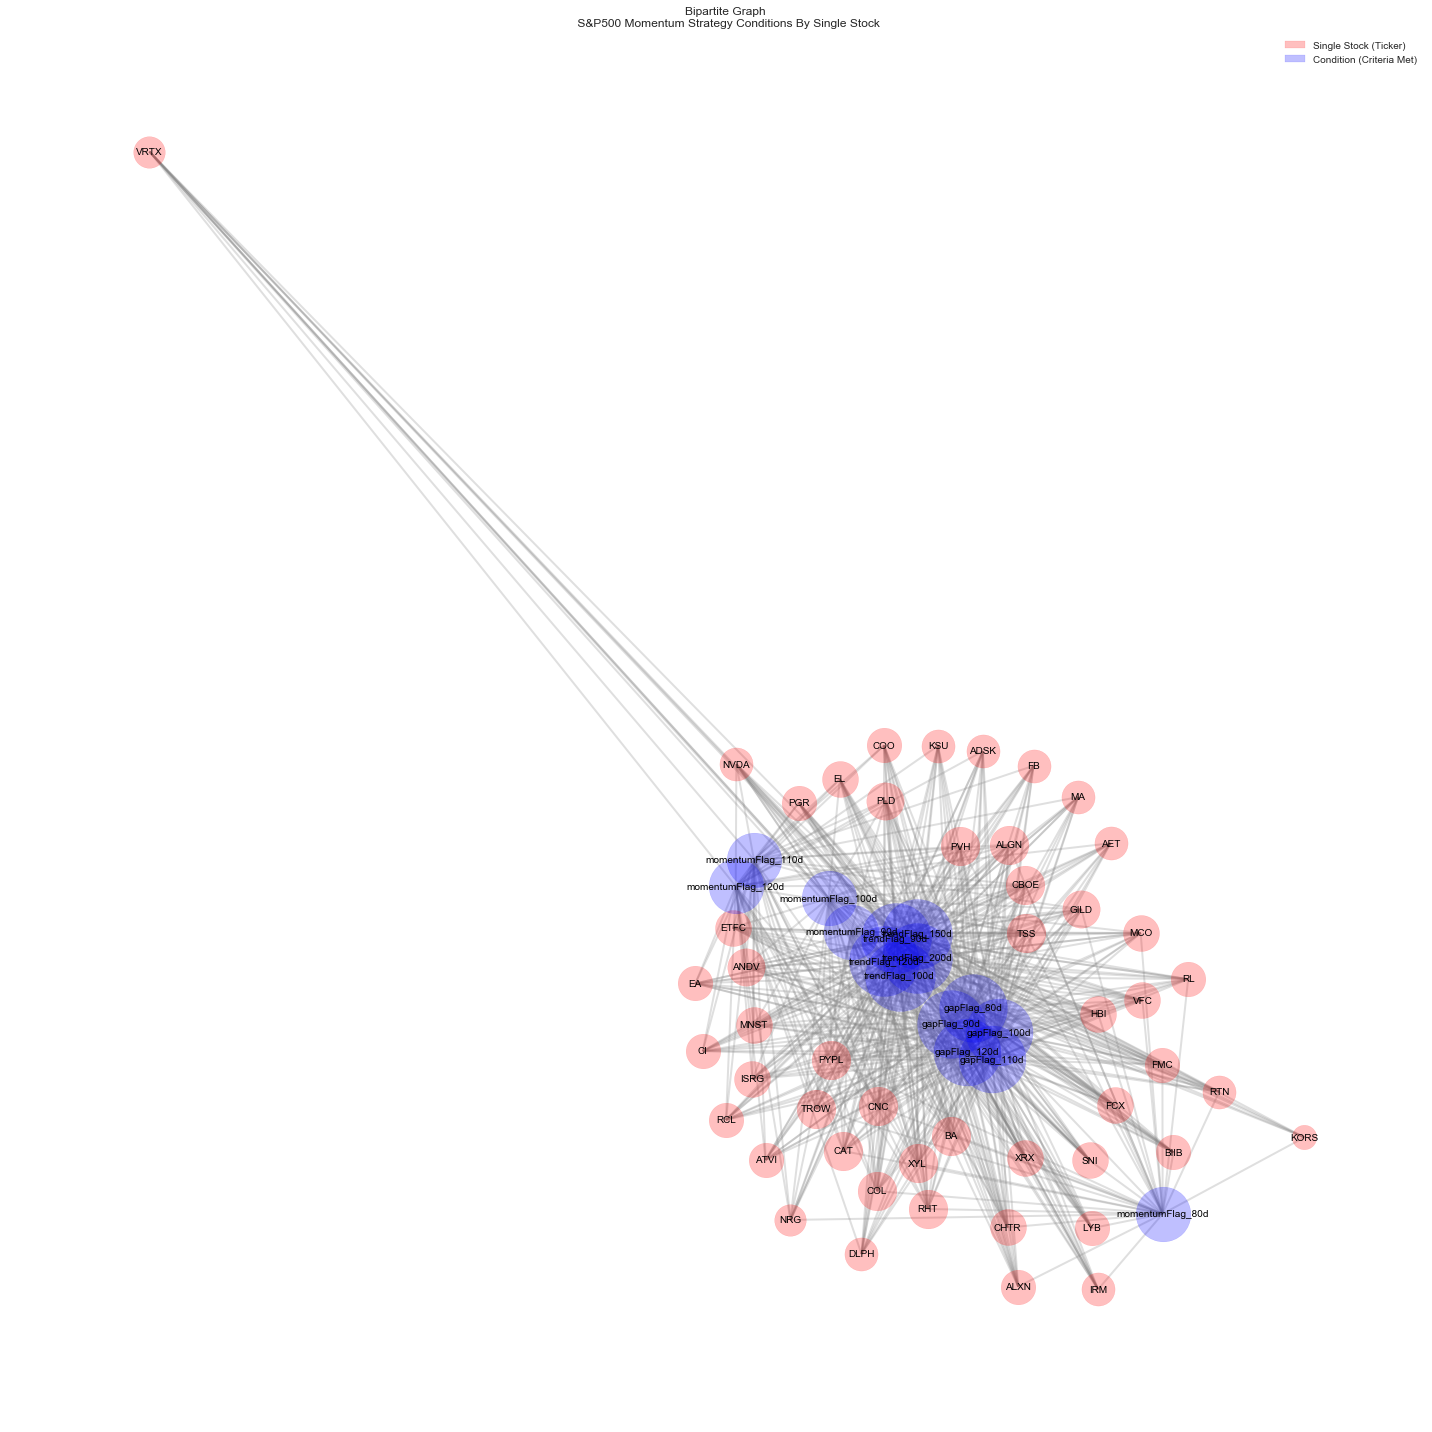

In [843]:
# determine the positions using spring layout
G_position=networkx.spring_layout(G)

# define plot formatting parameters
plotFontSize=10
plotAlpha=0.25
plotLabelsFlag=True
# color list
plotColorsList=list()
# legend color patch list
legendColorPatch=list()

# define title
titleName='Bipartite Graph \n S&P500 Momentum Strategy Conditions By Single Stock'
# set figure size
plt.figure(figsize=(20,20))
# add title
plt.title(titleName)

# extract labels (individual women and events)
tickerAndConditionLabels=list(degreeByNodeDf.index)
# extract single stock (ticker) labels
tickerLabels=list(ticker_degreeByNodeDf.index)
# extract condition (criteria met) labels
conditionLabels=list(condition_degreeByNodeDf.index)

# iterate over labels and assign color by group
for label in tickerAndConditionLabels:
    # if label is a single stock (ticker)
    if label in tickerLabels:
        # set node color red
        G.node[label]['color']='r'
        # set color red
        plotColorsList.append('r')
    # if label is a condition (criteria met)
    elif label in conditionLabels:
        #print(label)
        #print(tickerLabels)
        
        # set node color blue
        G.node[label]['color']='b'
        # set color blue
        plotColorsList.append('b')
        
    networkx.draw_networkx_nodes(G, G_position,[label], 
        node_size = degreeByNodeDf['degree'].loc[label]*100,
        node_color=G.node[label]['color'],alpha=plotAlpha,
        with_labels=plotLabelsFlag)

# add edges
networkx.draw_networkx_edges(G,pos=G_position,edge_color='grey',
    alpha=plotAlpha,width=2)

# add labels
networkx.draw_networkx_labels(G,pos=G_position,font_size=plotFontSize)
# remove axis
plt.axis('off')

# add legend color patch (stock)
colorPatch=mpatches.Patch(color='r', label='Single Stock (Ticker)',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)
# add legend color patch (condition)
colorPatch=mpatches.Patch(color='b', label='Condition (Criteria Met)',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)

# add legend
plt.legend(handles=legendColorPatch)

# set tight layout
plt.tight_layout()
# display the graph
plt.show()



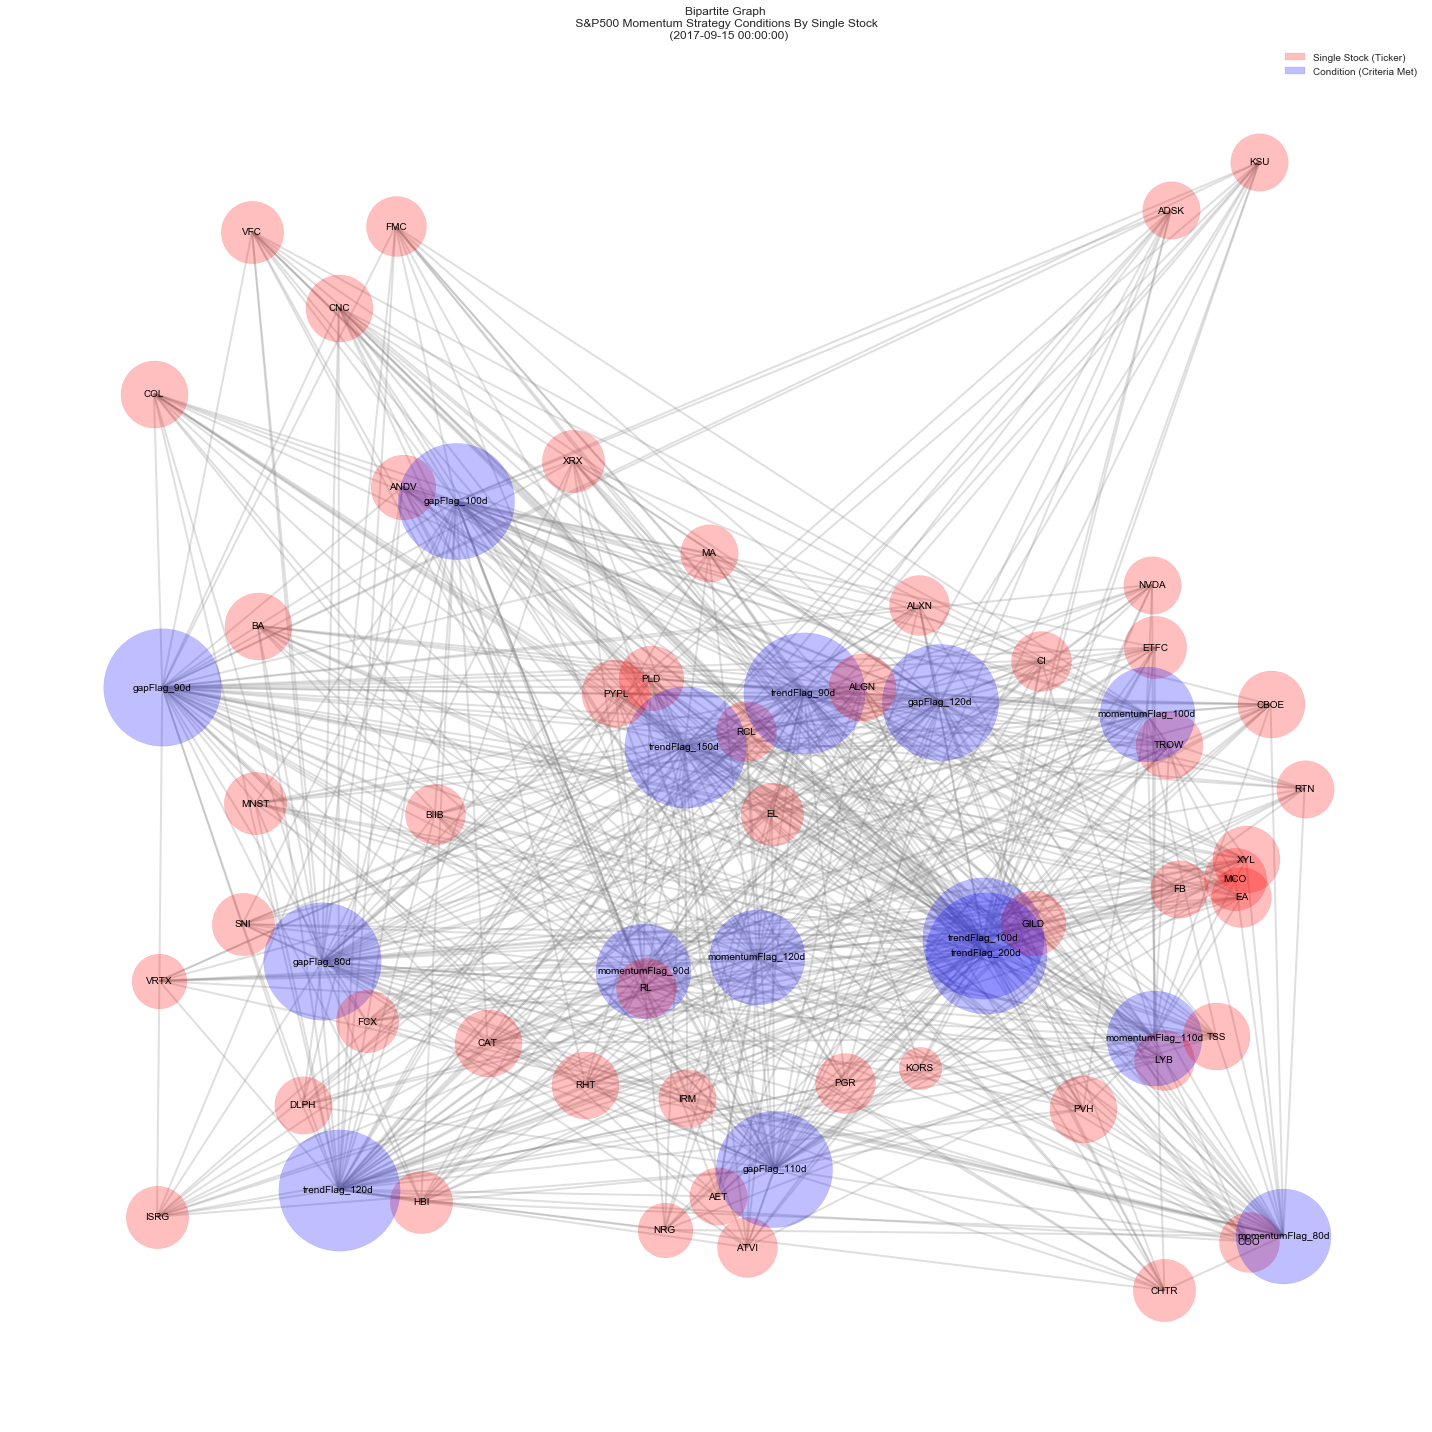

In [844]:
# determine the positions using spring layout
G_position=networkx.random_layout(G)

# define plot formatting parameters
plotFontSize=10
plotAlpha=0.25
plotLabelsFlag=True
# color list
plotColorsList=list()
# legend color patch list
legendColorPatch=list()

# define title
titleName='Bipartite Graph \n S&P500 Momentum Strategy Conditions By Single Stock \n ('+t+')'
# set figure size
plt.figure(figsize=(20,20))
# add title
plt.title(titleName)

# extract labels (individual women and events)
tickerAndConditionLabels=list(degreeByNodeDf.index)
# extract single stock (ticker) labels
tickerLabels=list(ticker_degreeByNodeDf.index)
# extract condition (criteria met) labels
conditionLabels=list(condition_degreeByNodeDf.index)

# iterate over labels and assign color by group
for label in tickerAndConditionLabels:
    # if label is a single stock (ticker)
    if label in tickerLabels:
        # set node color red
        G.node[label]['color']='r'
        # set color red
        plotColorsList.append('r')
    # if label is a condition (criteria met)
    elif label in conditionLabels:
        #print(label)
        #print(tickerLabels)
        
        # set node color blue
        G.node[label]['color']='b'
        # set color blue
        plotColorsList.append('b')
        
    networkx.draw_networkx_nodes(G, G_position,[label], 
        node_size = degreeByNodeDf['degree'].loc[label]*300,
        node_color=G.node[label]['color'],alpha=plotAlpha,
        with_labels=plotLabelsFlag)

# add edges
networkx.draw_networkx_edges(G,pos=G_position,edge_color='grey',
    alpha=plotAlpha,width=2)

# add labels
networkx.draw_networkx_labels(G,pos=G_position,font_size=plotFontSize)
# remove axis
plt.axis('off')

# add legend color patch (stock)
colorPatch=mpatches.Patch(color='r', label='Single Stock (Ticker)',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)
# add legend color patch (condition)
colorPatch=mpatches.Patch(color='b', label='Condition (Criteria Met)',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)

# add legend
plt.legend(handles=legendColorPatch)

# set tight layout
plt.tight_layout()
# display the graph
plt.show()

In the graph above it is very difficult to discern any clear pattern in the relationship between stocks or conditions.

The ticker-by-condition adjacency matrix, $A$, is as follows:

In [736]:
# find the adjacency matrix
Asc=bipartite.biadjacency_matrix(G,row_order=tickers,column_order=conditions)

In [737]:
# create the adjacency matrix table dataframe
biadjacencyMatrixTable=pandas.SparseDataFrame(Asc,index=tickers,
    columns=conditions)
# fill NaNs with zero
biadjacencyMatrixTable.fillna(0,inplace=True)
# display
biadjacencyMatrixTable

momentumFlag_80d  momentumFlag_90d  momentumFlag_100d  \
ADSK               0.0               0.0                0.0   
AET                0.0               0.0                0.0   
ALGN               1.0               1.0                1.0   
ALXN               1.0               1.0                0.0   
ANDV               0.0               1.0                1.0   
ATVI               0.0               0.0                0.0   
BA                 1.0               1.0                1.0   
BIIB               1.0               1.0                0.0   
CAT                1.0               1.0                1.0   
CBOE               1.0               1.0                1.0   
CHTR               1.0               1.0                1.0   
CI                 0.0               0.0                0.0   
CNC                1.0               1.0                1.0   
COL                1.0               1.0                1.0   
COO                0.0               0.0                0.0   
DLPH               0.0               0.0                0.0   
EA                 0.0               0.0                0.0   
EL                 0.0               0.0                1.0   
ETFC               0.0               1.0                1.0   
FB                 0.0               0.0                0.0   
FCX                1.0               1.0                1.0   
FMC                1.0               0.0                1.0   
GILD               1.0               1.0                1.0   
HBI                1.0               1.0                1.0   
IRM                1.0               0.0                0.0   
ISRG               0.0               0.0                1.0   
KORS               1.0               0.0                0.0   
KSU                0.0               0.0                0.0   
LYB                1.0               1.0                0.0   
MA                 0.0               0.0                0.0   
MCO                1.0               1.0                1.0   
MNST               0.0               0.0                1.0   
NRG                1.0               1.0                1.0   
NVDA               0.0               1.0                1.0   
PGR                0.0               0.0                0.0   
PLD                0.0               1.0                1.0   
PVH                1.0               1.0                1.0   
PYPL               1.0               1.0                1.0   
RCL                0.0               0.0                0.0   
RHT                1.0               1.0                1.0   
RL                 1.0               1.0                0.0   
RTN                1.0               0.0                0.0   
SNI                1.0               1.0                1.0   
TROW               1.0               1.0                1.0   
TSS                1.0               1.0                1.0   
VFC                1.0               1.0                1.0   
VRTX               1.0               1.0                1.0   
XRX                1.0               1.0                1.0   
XYL                1.0               1.0                1.0   

      momentumFlag_110d  momentumFlag_120d  gapFlag_80d  gapFlag_90d  \
ADSK                0.0                1.0          1.0          1.0   
AET                 0.0                1.0          1.0          1.0   
ALGN                1.0                1.0          1.0          1.0   
ALXN                0.0                0.0          1.0          1.0   
ANDV                1.0                1.0          1.0          1.0   
ATVI                1.0                1.0          1.0          1.0   
BA                  1.0                1.0          1.0          1.0   
BIIB                0.0                0.0          1.0          1.0   
CAT                 1.0                1.0          1.0          1.0   
CBOE                1.0                1.0          1.0          1.0   
CHTR                0.0                0.0          1.0        

## Bipartite Graph Projections 


#### Bipartite Projected Graph - Single Stock (Ticker)

$A \times A^T$ gives the number of criteria met by both the row and the column single stock (where $A$ is the adjacency matrix).

In [738]:
AxAT=Asc*Asc.transpose()

In [739]:
tickerXtickerTable=pandas.SparseDataFrame(AxAT,
index=tickers,columns=tickers)
# fill NaNs with zero
tickerXtickerTable.fillna(0,inplace=True)
# display
tickerXtickerTable

ADSK  AET  ALGN  ALXN  ANDV  ATVI  BA  BIIB  CAT  CBOE ...   RHT  RL  \
ADSK    11   11    11    10    11    11  11    10   11    11 ...    11  10   
AET     11   11    11    10    11    11  11    10   11    11 ...    11  10   
ALGN    11   11    15    12    14    12  15    12   15    15 ...    15  12   
ALXN    10   10    12    12    11    10  12    12   12    12 ...    12  12   
ANDV    11   11    14    11    14    12  14    11   14    14 ...    14  11   
ATVI    11   11    12    10    12    12  12    10   12    12 ...    12  10   
BA      11   11    15    12    14    12  15    12   15    15 ...    15  12   
BIIB    10   10    12    12    11    10  12    12   12    12 ...    12  12   
CAT     11   11    15    12    14    12  15    12   15    15 ...    15  12   
CBOE    11   11    15    12    14    12  15    12   15    15 ...    15  12   
CHTR    10   10    13    12    12    10  13    12   13    13 ...    13  12   
CI      11   11    12    10    12    12  12    10   12    12 ...    12  10   
CNC     11   11    15    12    14    12  15    12   15    15 ...    15  12   
COL     11   11    15    12    14    12  15    12   15    15 ...    15  12   
COO     11   11    12    10    12    12  12    10   12    12 ...    12  10   
DLPH    11   11    11    10    11    11  11    10   11    11 ...    11  10   
EA      11   11    12    10    12    12  12    10   12    12 ...    12  10   
EL      11   11    13    10    13    12  13    10   13    13 ...    13  10   
ETFC    10   10    13    11    13    11  13    11   13    13 ...    13  11   
FB      10   10    11    10    11    11  11    10   11    11 ...    11  10   
FCX     10   10    13    12    12    10  13    12   13    13 ...    13  12   
FMC     10   10    12    11    11    10  12    11   12    12 ...    12  11   
GILD    10   10    14    12    13    11  14    12   14    14 ...    14  12   
HBI     10   10    13    12    12    10  13    12   13    13 ...    13  12   
IRM     10   10    11    11    10    10  11    11   11    11 ...    11  11   
ISRG    11   11    13    10    13    12  13    10   13    13 ...    13  10   
KORS     5    5     6     6     5     5   6     6    6     6 ...     6   6   
KSU     11   11    11    10    11    11  11    10   11    11 ...    11  10   
LYB     10   10    12    12    11    10  12    12   12    12 ...    12  12   
MA      10   10    11    10    11    11  11    10   11    11 ...    11  10   
MCO     10   10    13    12    12    10  13    12   13    13 ...    13  12   
MNST    11   11    13    10    13    12  13    10   13    13 ...    13  10   
NRG      6    6    10     7     9     7  10     7   10    10 ...    10   7   
NVDA     8    8    11     8    11     9  11     8   11    11 ...    11   8   
PGR     11   11    12    10    12    12  12    10   12    12 ...    12  10   
PLD     11   11    14    11    14    12  14    11   14    14 ...    14  11   
PVH     11   11    15    12    14    12  15    12   15    15 ...    15  12   
PYPL    11   11    15    12    14    12  15    12   15    15 ...    15  12   
RCL     11   11    12    10    12    12  12    10   12    12 ...    12  10   
RHT     11   11    15    12    14    12  15    12   15    15 ...    15  12   
RL      10   10    12    12    11    10  12    12   12    12 ...    12  12   
RTN     10   10    11    11    10    10  11    11   11    11 ...    11  11   
SNI     10   10    13    12    12    10  13    12   13    13 ...    13  12   
TROW    11   11    15    12    14    12  15    12   15    15 ...    15  12   
TSS     11   11    15    12    14    12  15    12   15    15 ...    15  12   
VFC     10   10    13    12    12    10  13    12   13    13 ...    13  12   
VRTX     6    6    10     7     9     7  10     7   10    10 ...    10   7   
XRX     10   10    13    12    12    10  13    12   13    13 ...    13  12   
XYL     11   11    15    12    14    12  15    12   15    15 ...    15  12   

      RTN  SNI  TROW  TSS  VFC  VRTX  XRX  XYL  
ADSK   10   10    11   11   10     6   10   11  
AET    

In [803]:
# project bipartite graph onto 'ticker' nodes
#SS = bipartite.projected_graph(G, tickers)
SS = bipartite.weighted_projected_graph(G, tickers)

# compute degree
degreeByNodeSS=networkx.degree(SS)

In [855]:
# convert degree dictionary to dataframe
degreeByNodeSSDf=pandas.DataFrame.from_dict(degreeByNodeSS,
    orient='index')
# rename column
degreeByNodeSSDf.rename(columns={0 : 'degree'},inplace=True)
# display
degreeByNodeSSDf.sort_values(ascending=False,by=['degree'])

degree
KSU       48
EL        48
GILD      48
PYPL      48
EA        48
XRX       48
PVH       48
TROW      48
ISRG      48
MCO       48
MA        48
IRM       48
NRG       48
RHT       48
SNI       48
TSS       48
FCX       48
PLD       48
ALGN      48
FMC       48
KORS      48
CNC       48
XYL       48
ETFC      48
DLPH      48
HBI       48
ANDV      48
AET       48
CBOE      48
VFC       48
CI        48
CAT       48
RCL       48
FB        48
CHTR      48
NVDA      48
ADSK      48
COO       48
BA        48
MNST      48
BIIB      48
RTN       48
COL       48
VRTX      48
ATVI      48
LYB       48
RL        48
PGR       48
ALXN      48

#### Bipartite Projected Graph - Conditions

$A^T \times A$ gives the number of stocks that met both the row condition and the column condition (where $A$ is the adjacency matrix).

In [912]:
# project bipartite graph onto 'condition' nodes
#CC = bipartite.projected_graph(G, conditions)
CC = bipartite.weighted_projected_graph(G, conditions)

# compute degree
degreeByNodeCC=networkx.degree(CC)

In [913]:
# convert degree dictionary to dataframe
degreeByNodeCCDf=pandas.DataFrame.from_dict(degreeByNodeCC,
    orient='index')
# rename column
degreeByNodeCCDf.rename(columns={0 : 'degree'},inplace=True)
# display
degreeByNodeCCDf.sort_values(ascending=False,by=['degree'])

degree
momentumFlag_90d       14
gapFlag_90d            14
trendFlag_90d          14
trendFlag_100d         14
gapFlag_120d           14
momentumFlag_80d       14
momentumFlag_100d      14
momentumFlag_110d      14
trendFlag_150d         14
gapFlag_110d           14
trendFlag_120d         14
trendFlag_200d         14
gapFlag_80d            14
gapFlag_100d           14
momentumFlag_120d      14

In [ ]:
# find the adjacency matrix
Acs=bipartite.biadjacency_matrix(G,row_order=conditions,
    column_order=tickers)

In [791]:
AxATcs=Acs*Acs.transpose()

In [807]:
conditionXconditionTable=pandas.SparseDataFrame(AxATcs,
    index=conditions,columns=conditions)
# fill NaNs with zero
conditionXconditionTable.fillna(0,inplace=True)
# display
conditionXconditionTable

momentumFlag_80d  momentumFlag_90d  momentumFlag_100d  \
momentumFlag_80d                 30                26                 23   
momentumFlag_90d                 26                30                 26   
momentumFlag_100d                23                26                 30   
momentumFlag_110d                15                19                 22   
momentumFlag_120d                14                17                 20   
gapFlag_80d                      27                28                 28   
gapFlag_90d                      27                28                 28   
gapFlag_100d                     27                27                 27   
gapFlag_110d                     27                27                 27   
gapFlag_120d                     27                27                 27   
trendFlag_90d                    30                30                 30   
trendFlag_100d                   30                30                 30   
trendFlag_120d                   30                30                 30   
trendFlag_150d                   30                30                 30   
trendFlag_200d                   30                30                 30   

                   momentumFlag_110d  momentumFlag_120d  gapFlag_80d  \
momentumFlag_80d                  15                 14           27   
momentumFlag_90d                  19                 17           28   
momentumFlag_100d                 22                 20           28   
momentumFlag_110d                 30                 26           28   
momentumFlag_120d                 26                 30           28   
gapFlag_80d                       28                 28           46   
gapFlag_90d                       28                 28           46   
gapFlag_100d                      27                 27           45   
gapFlag_110d                      27                 27           45   
gapFlag_120d                      27                 27           45   
trendFlag_90d                     30                 30           46   
trendFlag_100d                    30                 30           46   
trendFlag_120d                    30                 30           46   
trendFlag_150d                    30                 30           46   
trendFlag_200d                    30                 30           46   

                   gapFlag_90d  gapFlag_100d  gapFlag_110d  gapFlag_120d  \
momentumFlag_80d            27            27            27            27   
momentumFlag_90d            28            27            27            27   
momentumFlag_100d           28            27            27            27   
momentumFlag_110d           28            27            27            27   
momentumFlag_120d           28            27            27            27   
gapFlag_80d                 46            45            45            45   
gapFlag_90d                 46            45            45            45   
gapFlag_100d                45            45            45            45   
gapFlag_110d                45            45            45            45   
gapFlag_120d                45            45            45            45   
trendFlag_90d               46            45            45            45   
trendFlag_100d              46            45            45            45   
trendFlag_120d              46            45            45            45   
trendFlag_150d              46            45            45            45   
trendFlag_200d              46            45            45            45   

                   trendFlag_90d  trendFlag_100d  trendFlag_120d  \
momentumFlag_80d              30              30              30   
momentumFlag_90d              30              30              30   
momentumFlag_100d             30              30              30   
momentumFlag_110d             30              30              30   
momentumFlag_120d             30              30              30   
gapFlag_80d             

### Centrality Metrics

The closeness of a node is the distance to all other nodes in the graph or in the case that the graph is not connected to all other nodes in the connected component containing that node.

Compute the closeness centrality for nodes in our bipartite network:

In [889]:
# compute closeness centrality for nodes in bipartite network
closenessCentralityByNodeSS=networkx.closeness_centrality(SS,normalized=True)
closenessCentralityByNodeCC=networkx.closeness_centrality(CC,normalized=True)

In [890]:
# convert degree dictionary to dataframe
closenessCentralityByNodeSSDf=pandas.DataFrame.from_dict(closenessCentralityByNodeSS,
    orient='index')
# rename column
closenessCentralityByNodeSSDf.rename(columns={0 : 'closeness'},inplace=True)
# display result
#closenessCentralityByNodeDf.sort_values(ascending=False,by=['closeness'])

# convert degree dictionary to dataframe
closenessCentralityByNodeCCDf=pandas.DataFrame.from_dict(closenessCentralityByNodeCC,
    orient='index')
# rename column
closenessCentralityByNodeCCDf.rename(columns={0 : 'closeness'},inplace=True)
# display result
#closenessCentralityByNodeDf.sort_values(ascending=False,by=['closeness'])

Betweenness centrality of a node is the sum of the fraction of all-pairs shortest paths that pass through the node. Values of betweenness are normalized by the maximum possible value. For bipartite graphs this maximum is limited by the relative size of the two node sets.

Compute betweenness centrality for nodes in our bipartite network as follows:

In [892]:
# compute betweenness centrality for nodes in bipartite network
betweennessCentralityByNodeSS=networkx.betweenness_centrality(SS)
betweennessCentralityByNodeCC=networkx.betweenness_centrality(CC)

In [893]:
# convert degree dictionary to dataframe
betweennessCentralityByNodeSSDf=pandas.DataFrame.from_dict(betweennessCentralityByNodeSS,
    orient='index')
# rename column
betweennessCentralityByNodeSSDf.rename(columns={0 : 'betweenness'},inplace=True)
# display result
#betweennessCentralityByNodeDf.sort_values(ascending=False,by=['betweenness'])

# convert degree dictionary to dataframe
betweennessCentralityByNodeCCDf=pandas.DataFrame.from_dict(betweennessCentralityByNodeCC,
    orient='index')
# rename column
betweennessCentralityByNodeCCDf.rename(columns={0 : 'betweenness'},inplace=True)
# display result
#betweennessCentralityByNodeDf.sort_values(ascending=False,by=['betweenness'])

The degree centrality for a node  is the fraction of nodes connected to it.

Compute the degree centrality for nodes in our bipartite network as follows:

In [894]:
# compute degree centrality for nodes in bipartite network
degreeCentralityByNodeSS=networkx.degree_centrality(SS)
degreeCentralityByNodeCC=networkx.degree_centrality(CC)

In [895]:
# convert degree dictionary to dataframe
degreeCentralityByNodeSSDf=pandas.DataFrame.from_dict(degreeCentralityByNodeSS,
    orient='index')
# rename column
degreeCentralityByNodeSSDf.rename(columns={0 : 'degree'},inplace=True)
#
#degreeCentralityByNodeDf.sort_values(ascending=False,by=['degree'])

# convert degree dictionary to dataframe
degreeCentralityByNodeCCDf=pandas.DataFrame.from_dict(degreeCentralityByNodeCC,
    orient='index')
# rename column
degreeCentralityByNodeCCDf.rename(columns={0 : 'degree'},inplace=True)
#
#degreeCentralityByNodeDf.sort_values(ascending=False,by=['degree'])

Compute the number of triangles associated with each node:

In [896]:
# triangles
triangesByNodeSS = networkx.triangles(SS)
triangesByNodeCC = networkx.triangles(CC)

In [897]:
# convert degree dictionary to dataframe
triangesByNodeSSDf=pandas.DataFrame.from_dict(triangesByNodeSS,
    orient='index')
# rename column
triangesByNodeSSDf.rename(columns={0 : 'triangles'},inplace=True)
#
#triangesByNodeDf.sort_values(ascending=False,by=['triangles'])

# convert degree dictionary to dataframe
triangesByNodeCCDf=pandas.DataFrame.from_dict(triangesByNodeCC,
    orient='index')
# rename column
triangesByNodeCCDf.rename(columns={0 : 'triangles'},inplace=True)
#
#triangesByNodeDf.sort_values(ascending=False,by=['triangles'])

Create the metric summary table:

In [898]:
# add degree and betweenness to table
metricsByNodeTableSS=pandas.merge(degreeCentralityByNodeSSDf, 
    betweennessCentralityByNodeSSDf, how='outer', left_index=True, right_index=True)
# add closeness to table
metricsByNodeTableSS=pandas.merge(metricsByNodeTableSS, 
    closenessCentralityByNodeSSDf, how='outer', left_index=True, right_index=True)
# add triangles
metricsByNodeTableSS=pandas.merge(metricsByNodeTableSS, 
    triangesByNodeSSDf, how='outer', left_index=True, right_index=True)

# add degree and betweenness to table
metricsByNodeTableCC=pandas.merge(degreeCentralityByNodeCCDf, 
    betweennessCentralityByNodeCCDf, how='outer', left_index=True, right_index=True)
# add closeness to table
metricsByNodeTableCC=pandas.merge(metricsByNodeTableCC, 
    closenessCentralityByNodeCCDf, how='outer', left_index=True, right_index=True)
# add triangles
metricsByNodeTableCC=pandas.merge(metricsByNodeTableCC, 
    triangesByNodeCCDf, how='outer', left_index=True, right_index=True)

Show the centrality metrics:

In [818]:
# sort by degree
metricsByNodeTableSS=metricsByNodeTableSS.sort_values(ascending=False,by=['degree'])
# display
metricsByNodeTableSS

degree  betweenness  closeness  triangles
KSU      1.0          0.0        1.0       1128
EL       1.0          0.0        1.0       1128
GILD     1.0          0.0        1.0       1128
PYPL     1.0          0.0        1.0       1128
EA       1.0          0.0        1.0       1128
XRX      1.0          0.0        1.0       1128
PVH      1.0          0.0        1.0       1128
TROW     1.0          0.0        1.0       1128
ISRG     1.0          0.0        1.0       1128
MCO      1.0          0.0        1.0       1128
MA       1.0          0.0        1.0       1128
IRM      1.0          0.0        1.0       1128
NRG      1.0          0.0        1.0       1128
RHT      1.0          0.0        1.0       1128
SNI      1.0          0.0        1.0       1128
TSS      1.0          0.0        1.0       1128
FCX      1.0          0.0        1.0       1128
PLD      1.0          0.0        1.0       1128
ALGN     1.0          0.0        1.0       1128
FMC      1.0          0.0        1.0       1128
KORS     1.0          0.0        1.0       1128
CNC      1.0          0.0        1.0       1128
XYL      1.0          0.0        1.0       1128
ETFC     1.0          0.0        1.0       1128
DLPH     1.0          0.0        1.0       1128
HBI      1.0          0.0        1.0       1128
ANDV     1.0          0.0        1.0       1128
AET      1.0          0.0        1.0       1128
CBOE     1.0          0.0        1.0       1128
VFC      1.0          0.0        1.0       1128
CI       1.0          0.0        1.0       1128
CAT      1.0          0.0        1.0       1128
RCL      1.0          0.0        1.0       1128
FB       1.0          0.0        1.0       1128
CHTR     1.0          0.0        1.0       1128
NVDA     1.0          0.0        1.0       1128
ADSK     1.0          0.0        1.0       1128
COO      1.0          0.0        1.0       1128
BA       1.0          0.0        1.0       1128
MNST     1.0          0.0        1.0       1128
BIIB     1.0          0.0        1.0       1128
RTN      1.0          0.0        1.0       1128
COL      1.0          0.0        1.0       1128
VRTX     1.0          0.0        1.0       1128
ATVI     1.0          0.0        1.0       1128
LYB      1.0          0.0        1.0       1128
RL       1.0          0.0        1.0       1128
PGR      1.0          0.0        1.0       1128
ALXN     1.0          0.0        1.0       1128

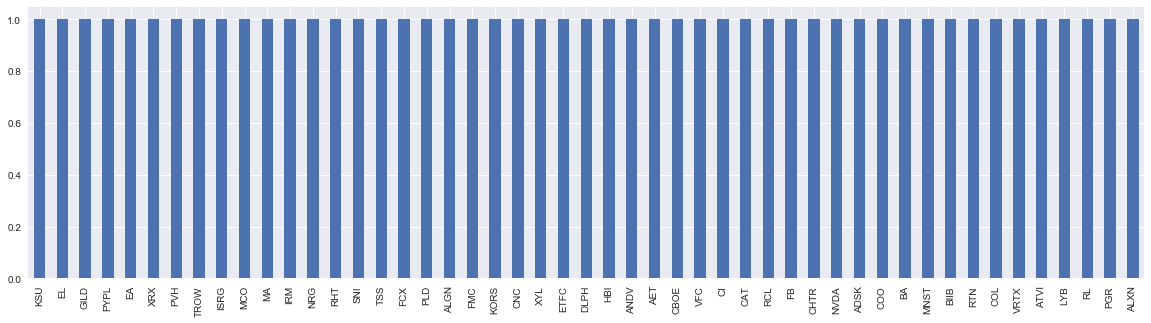

In [766]:
# set figure size
plt.figure(figsize=(20,5))
# plot degree
metricsByNodeTable['degree'].plot('bar')

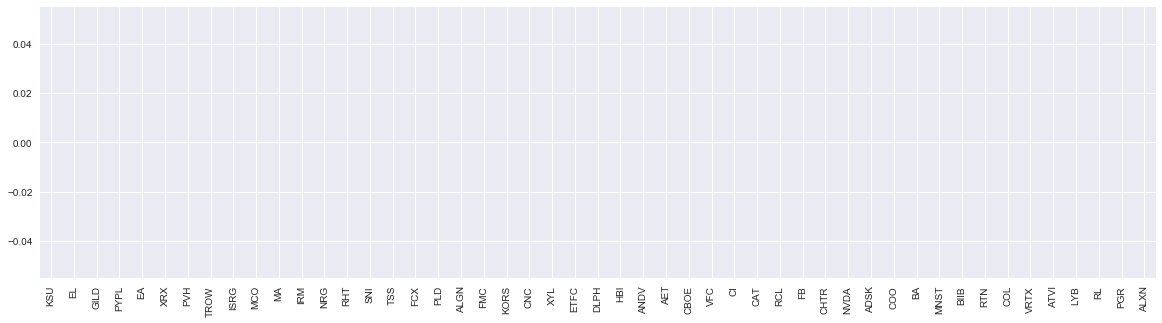

In [767]:
# set figure size
plt.figure(figsize=(20,5))
# plot degree
metricsByNodeTable['betweenness'].plot('bar')

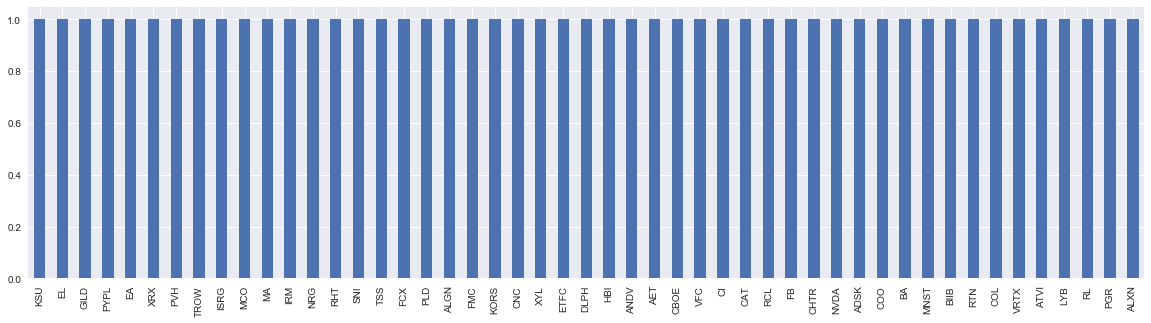

In [768]:
# set figure size
plt.figure(figsize=(20,5))
# plot degree
metricsByNodeTable['closeness'].plot('bar')

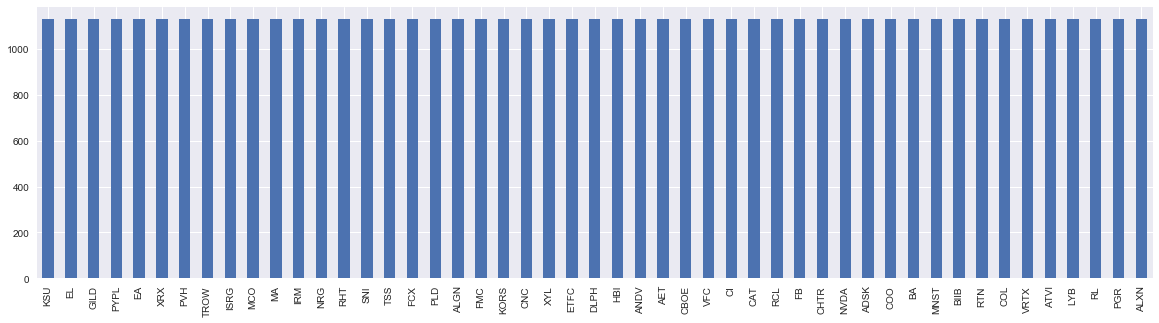

In [769]:
# set figure size
plt.figure(figsize=(20,5))
# plot degree
metricsByNodeTable['triangles'].plot('bar')

In [899]:
# sort by degree
metricsByNodeTableCC=metricsByNodeTableCC.sort_values(ascending=False,by=['degree'])
# display
metricsByNodeTableCC

degree  betweenness  closeness  triangles
momentumFlag_90d      1.0          0.0        1.0         91
gapFlag_90d           1.0          0.0        1.0         91
trendFlag_90d         1.0          0.0        1.0         91
trendFlag_100d        1.0          0.0        1.0         91
gapFlag_120d          1.0          0.0        1.0         91
momentumFlag_80d      1.0          0.0        1.0         91
momentumFlag_100d     1.0          0.0        1.0         91
momentumFlag_110d     1.0          0.0        1.0         91
trendFlag_150d        1.0          0.0        1.0         91
gapFlag_110d          1.0          0.0        1.0         91
trendFlag_120d        1.0          0.0        1.0         91
trendFlag_200d        1.0          0.0        1.0         91
gapFlag_80d           1.0          0.0        1.0         91
gapFlag_100d          1.0          0.0        1.0         91
momentumFlag_120d     1.0          0.0        1.0         91

Centrality metrics provide no indication of any communities in either stocks or conditions.

## Community Detection

In this section, we employ two methods of community detection.

### Island Method

We define functions to implement the island method of community detection:

In [820]:
def trimEdges(G, weightThreshold = 1):
    # trim of graph edges for island method
    G2 = networkx.Graph()
    for fromNode, toNode, edgeData in G.edges(data=True):
        # if weight is greater than weight threshold
        if edgeData['weight'] > weightThreshold:
            # add edge 
            G2.add_edge(fromNode,toNode,edgeData)
    # return trimmed graph
    return G2

def islandMethod(G, nIterations = 5):
    # extract weights
    weights = [edgeData['weight'] for fromNode,toNode,edgeData in G.edges(data=True)]
    # find minimum weights
    minWeights=int(min(weights))
    # find maximum weights
    maxWeights=int(max(weights))
    # find step size
    stepSize = int((maxWeights-minWeights)/nIterations)
    # weight range
    weightRange=range(minWeights,maxWeights,stepSize)
    # return number of edges removed and trimmed graph
    return [[threshold, trimEdges(G, threshold)] for threshold in weightRange]

#### Single Stocks

First, we employ the island method to identify communities of stocks as follows:

In [845]:
# find connected component subgraphs of projected graph (stocks)
connectedComponentsSS=networkx.connected_component_subgraphs(SS)
# extract connected components into list
connectedComponentsListSS = list(connectedComponentsSS)
# extract subgraph
subGraphSS=connectedComponentsListSS[0]
# apply island method
islandsSS = islandMethod(subGraphSS)
# create table
table=list()
# iterate over island
for islandSS in islandsSS:
    # extract island details
    row=[islandSS[0],len(islandSS[1]),len(list(networkx.connected_component_subgraphs(islandSS[1])))]
    # add island details to table
    table.append(row)
# create dataframe table
islandSSTable=pandas.DataFrame(table,columns=['depth','nStocks','nGroups'])

In [846]:
# display table
islandSSTable

depth  nStocks  nGroups
0      5       49        1
1      7       48        1
2      9       48        1
3     11       37        1
4     13       15        1

#### Conditions

Next we employ the island method to detect communities of conditions as follows:

In [874]:
# find connected component subgraphs of projected graph (stocks)
connectedComponentsCC=networkx.connected_component_subgraphs(CC)
# extract connected components into list
connectedComponentsListCC = list(connectedComponentsCC)
# extract subgraph
subGraphCC=connectedComponentsListCC[0]
# apply island method
islandsCC = islandMethod(subGraphCC)
# create table
table=list()
# iterate over island
for islandCC in islandsCC:
    # extract island details
    row=[islandCC[0],len(islandCC[1]),
        len(list(networkx.connected_component_subgraphs(islandCC[1])))]
    # add island details to table
    table.append(row)
# create dataframe table
islandCCTable=pandas.DataFrame(table,columns=['depth','nStocks','nGroups'])

In [875]:
# display table
islandCCTable

depth  nStocks  nGroups
0     14       15        1
1     21       15        1
2     28       15        1
3     35       10        1
4     42       10        1

We are unable to detect any communities using the island method in either stocks or conditions.

### Best Partition


We define the best partition as the partition of highest modularity (i.e. the highest partition of the dendrogram generated by the Louvain algorithm).

Compute the best partition of the stock-by-stock graph as follows:

In [847]:
# first compute the best partition
partition = community.best_partition(SS)

Create a table to summarize the metrics:

In [848]:
# convert degree dictionary to dataframe
partitionDf=pandas.DataFrame.from_dict(partition,
    orient='index')
# rename column
partitionDf.rename(columns={0 : 'best partition'},inplace=True)
# display result
#partitionDf.sort_values(ascending=False,by=['partition'])

In [910]:
# add partition to degree summary table
summaryTableSS=pandas.merge(instrumentMaster, 
    partitionDf, how='right', left_on='Ticker symbol', right_index=True)

summaryTableSS=pandas.merge(summaryTableSS, 
    ticker_degreeByNodeDf, how='right', left_on='Ticker symbol', right_index=True)

summaryTableSS=pandas.merge(summaryTableSS, 
    AA, how='left', left_on='Ticker symbol', right_index=True)

# fill NaNs with empty string
summaryTableSS.fillna('',inplace=True)

# add instrument master data


In [911]:
summaryTableSS.sort_values(ascending=False,by=['GICS Sector',
    'GICS Sub Industry','best partition'])

Ticker symbol                           Security             GICS Sector  \
347           NRG                         NRG Energy               Utilities   
261           IRM         Iron Mountain Incorporated             Real Estate   
381           PLD                           Prologis             Real Estate   
293           LYB                     LyondellBasell               Materials   
203           FMC                    FMC Corporation               Materials   
209           FCX              Freeport-McMoRan Inc.               Materials   
497           XRX                        Xerox Corp.  Information Technology   
396           RHT                       Red Hat Inc.  Information Technology   
349          NVDA                 Nvidia Corporation  Information Technology   
446           TSS              Total System Services  Information Technology   
192            FB                     Facebook, Inc.  Information Technology   
303            MA                    Mastercard Inc.  Information Technology   
4            ATVI                Activision Blizzard  Information Technology   
172            EA                    Electronic Arts  Information Technology   
360          PYPL                             PayPal  Information Technology   
58           ADSK                       Autodesk Inc  Information Technology   
269           KSU               Kansas City Southern             Industrials   
500           XYL                         Xylem Inc.             Industrials   
94            CAT                   Caterpillar Inc.             Industrials   
76             BA                     Boeing Company             Industrials   
404           COL                   Rockwell Collins             Industrials   
394           RTN                       Raytheon Co.             Industrials   
98            CNC                Centene Corporation             Health Care   
10            AET                          Aetna Inc             Health Care   
110            CI                        CIGNA Corp.             Health Care   
20           ALGN                   Align Technology             Health Care   
132           COO               The Cooper Companies             Health Care   
259          ISRG            Intuitive Surgical Inc.             Health Care   
219          GILD                    Gilead Sciences             Health Care   
474          VRTX         Vertex Pharmaceuticals Inc             Health Care   
19           ALXN            Alexion Pharmaceuticals             Health Care   
73           BIIB                        Biogen Inc.             Health Care   
380           PGR                  Progressive Corp.              Financials   
165          ETFC                            E*Trade              Financials   
91           CBOE                      CBOE Holdings              Financials   
323           MCO                       Moody's Corp              Financials   
435          TROW                T. Rowe Price Group              Financials   
44           ANDV                           Andeavor                  Energy   
322          MNST                   Monster Beverage        Consumer Staples   
182            EL                  Estee Lauder Cos.        Consumer Staples   
407           RCL        Royal Caribbean Cruises Ltd  Consumer Discretionary   
104          CHTR             Charter Communications  Consumer Discretionary   
412           SNI  Scripps Networks Interactive Inc.  Consumer Discretionary   
146          DLPH              Delphi Automotive PLC  Consumer Discretionary   
386           PVH                          PVH Corp.  Consumer Discretionary   
225           HBI                    Hanesbrands Inc  Consumer Discretionary   
313          KORS              Michael Kors Holdings  Consumer Discretionary   
373            RL            Polo Ralph Lauren Corp.  Consumer Discretionary   
467           VFC                         V.F. Corp.  Consumer Discretionary   

   

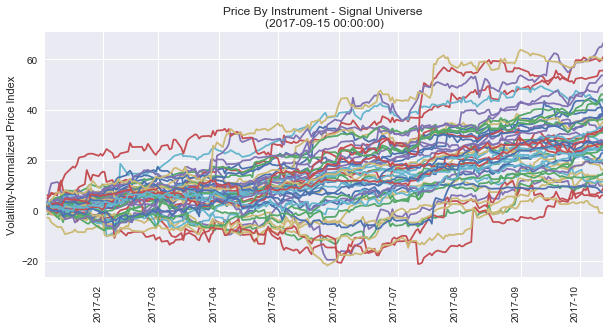

In [869]:
# log price by instrument
logPrices=numpy.log(prices.loc['2017-01-01':])
# first difference to get returns
logReturns=logPrices.diff(periods=1,axis=0)

fStd=lambda x : x/numpy.std(x)
# standardize log returns
stdLogReturnsWithMean=logReturns.apply(fStd,axis=1)

# define title
titleName='Price By Instrument - Signal Universe \n'+'('+t+')'
# create variability-normalized price index
standardizedLogPricesWithMean=stdLogReturnsWithMean.cumsum(axis=0)
# plot price index
standardizedLogPricesWithMean[tickers].plot(legend=False,figsize=(10,5),
    rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Volatility-Normalized Price Index")

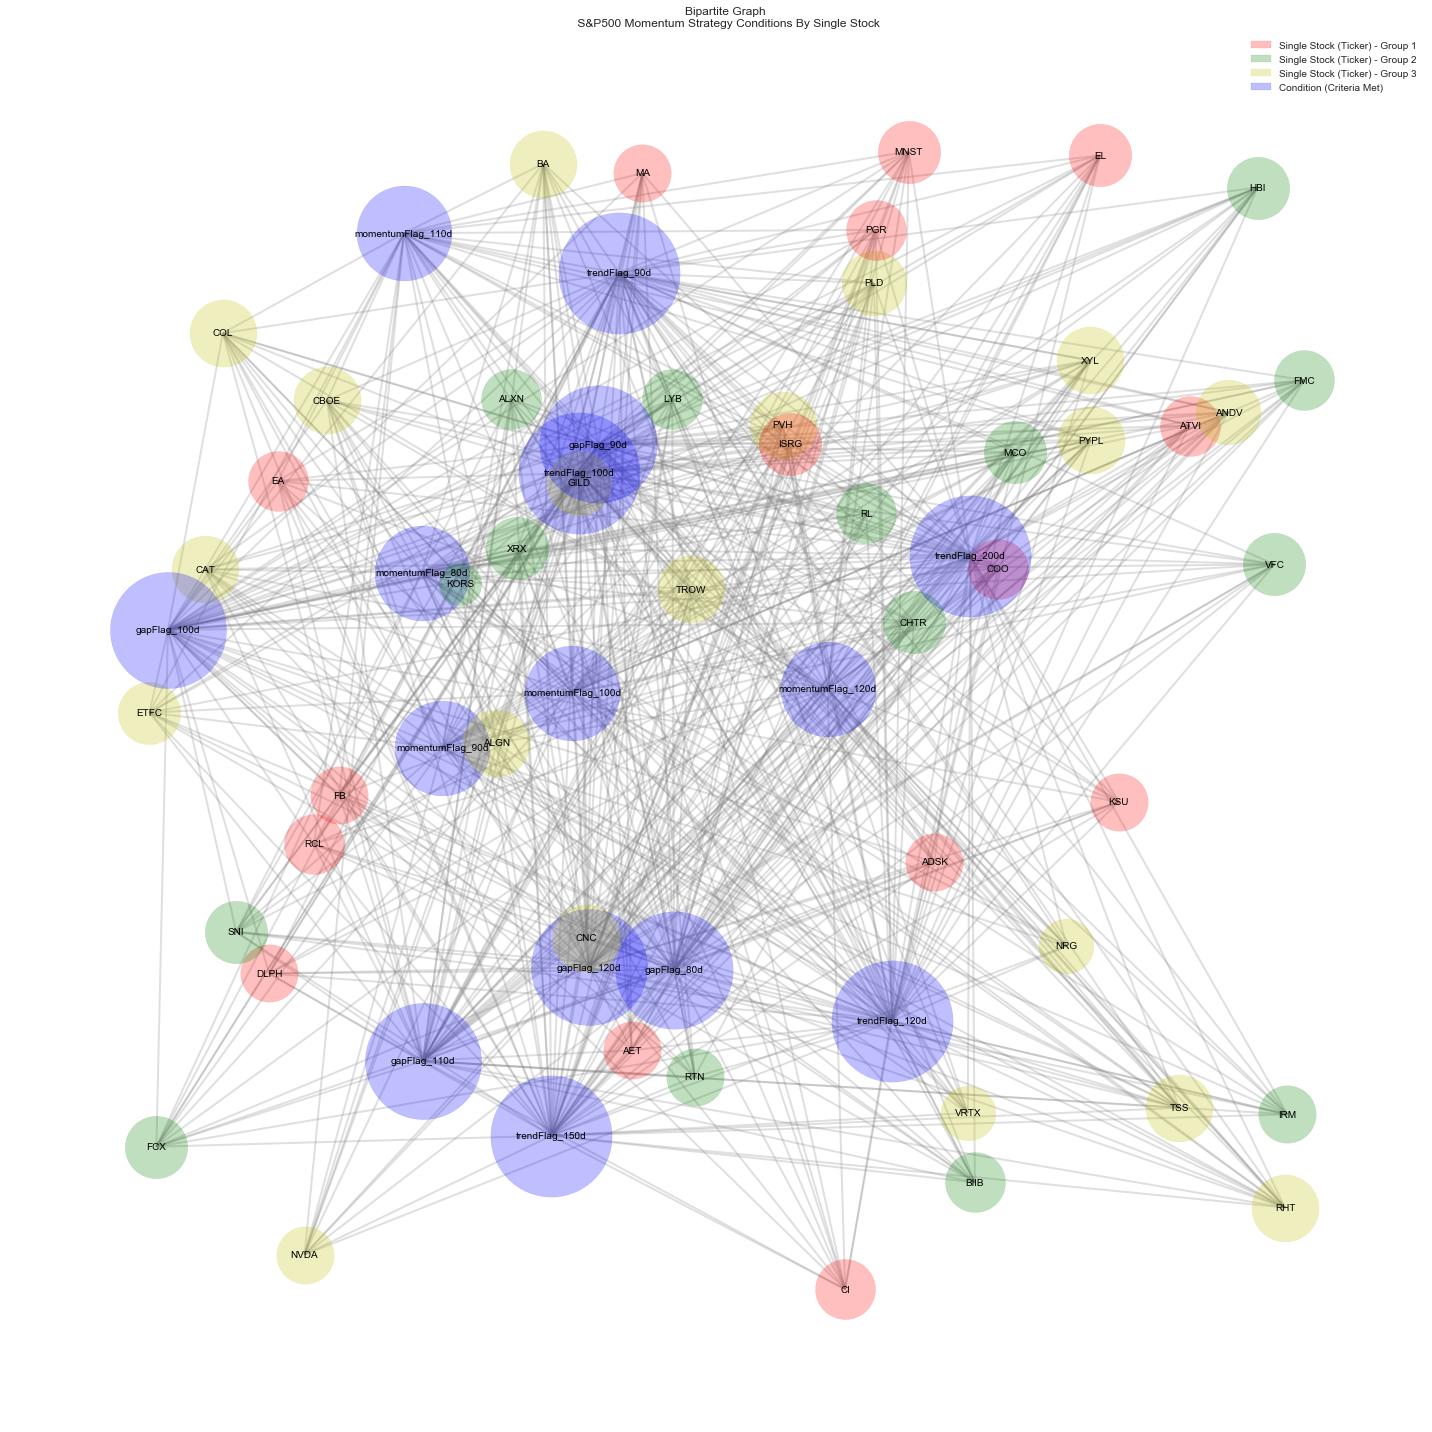

In [833]:
GG=G

# determine the positions using spring layout
GG_position=networkx.random_layout(GG)

# define plot formatting parameters
plotFontSize=10
plotAlpha=0.25
plotLabelsFlag=True
# color list
plotColorsList=list()
# legend color patch list
legendColorPatch=list()

# define title
titleName='Bipartite Graph \n S&P500 Momentum Strategy Conditions By Single Stock'
# set figure size
plt.figure(figsize=(20,20))
# add title
plt.title(titleName)

# extract labels (individual women and events)
tickerAndConditionLabels=list(degreeByNodeDf.index)
# extract single stock (ticker) labels
tickerLabels=list(ticker_degreeByNodeDf.index)
# extract condition (criteria met) labels
conditionLabels=list(condition_degreeByNodeDf.index)

# iterate over labels and assign color by group
for label in tickerAndConditionLabels:
    # if label is a single stock (ticker)
    if label in tickerLabels:
        
        group=partition[label]
        # if group 1
        if group == 0:
            # set color red
            plotColorsList.append('r')
            # set node color red
            GG.node[label]['color']='r'

        # if group 2
        elif group == 1:
            # set color green
            plotColorsList.append('g')
            # set node color red
            GG.node[label]['color']='g'        
        
        elif group == 2:
            # set color green
            plotColorsList.append('y')        
            # set node color red
            GG.node[label]['color']='y'        
        
    # if label is a condition (criteria met)
    elif label in conditionLabels:
        #print(label)
        #print(tickerLabels)
        
        # set node color blue
        GG.node[label]['color']='b'
        # set color blue
        plotColorsList.append('b')
        
    networkx.draw_networkx_nodes(GG, GG_position,[label], 
        node_size = degreeByNodeDf['degree'].loc[label]*300,
        node_color=GG.node[label]['color'],alpha=plotAlpha,
        with_labels=plotLabelsFlag)

# add edges
networkx.draw_networkx_edges(GG,pos=GG_position,edge_color='grey',
    alpha=plotAlpha,width=2)

# add labels
networkx.draw_networkx_labels(GG,pos=GG_position,font_size=plotFontSize)
# remove axis
plt.axis('off')

# add legend color patch (stock - group 1)
colorPatch=mpatches.Patch(color='r', label='Single Stock (Ticker) - Group 1',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)

# add legend color patch (stock - group 2)
colorPatch=mpatches.Patch(color='g', label='Single Stock (Ticker) - Group 2',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)

# add legend color patch (stock - group 3)
colorPatch=mpatches.Patch(color='y', label='Single Stock (Ticker) - Group 3',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)

# add legend color patch (condition)
colorPatch=mpatches.Patch(color='b', label='Condition (Criteria Met)',
    alpha=plotAlpha)
legendColorPatch.append(colorPatch)

# add legend
plt.legend(handles=legendColorPatch)

# set tight layout
plt.tight_layout()
# display the graph
plt.show()

Compute the best partition of the condition-by-condition graph as follows:

In [870]:
# first compute the best partition
partitionCC = community.best_partition(CC)

Create a table to summarize the metrics:

In [900]:
# convert degree dictionary to dataframe
partitionCCDf=pandas.DataFrame.from_dict(partitionCC,
    orient='index')
# rename column
partitionCCDf.rename(columns={0 : 'best partition'},inplace=True)
# display result
#partitionDf.sort_values(ascending=False,by=['partition'])

In [917]:
# add partition to degree summary table
summaryTableCC=pandas.merge(condition_degreeByNodeDf, 
    partitionCCDf, how='right', left_index=True, right_index=True)

# fill NaNs with empty string
summaryTableCC.fillna('',inplace=True)

In [918]:
summaryTableCC.loc[conditions]

degree  best partition
momentumFlag_80d       30               0
momentumFlag_90d       30               0
momentumFlag_100d      30               0
momentumFlag_110d      30               0
momentumFlag_120d      30               0
gapFlag_80d            46               0
gapFlag_90d            46               0
gapFlag_100d           45               0
gapFlag_110d           45               0
gapFlag_120d           45               0
trendFlag_90d          49               0
trendFlag_100d         49               0
trendFlag_120d         49               0
trendFlag_150d         49               0
trendFlag_200d         49               0

No communities are identified for the condition-by-condition graph.

## Conclusion

Our analysis identified 3 main groups within the total set of single stocks with high momentum ranks, but no condition communities. The identified stock groups had no discernible pattern based on sector or sub-industry.

We computed several metrics, including centrality measures (betweenness, closeness, and degree) and the number triangles. These metrics did not aid in uncovering structure in the graph.

Further work is required to uncover interpretable structure in our stock-by-condition graph.

## References

Kouznetsov, A. & Tsvetovat, M. (2011) Social Network Analysis for Startups. O’Reilly Media.

Blondel, V. D., Guillaume, J., Lambiotte, R., & Lefebvre, R. (2008) Fast Unfolding of Communities in Large Networks. Journal of Statistical Mechanics: Theory and Experiment.